## Differential expression analysis 

Differential expression analysis is a group of statistical tests that are used to establish whether there a exists a significant variation across a set of tested conditions for each gene. In its easiset form, this test can test for the difference between two distinct groups: This scenario can be handled with (Welch's) T-test, rank sum tests or Wald and likelihood ratio tests (LRT). Wald tests and LRT allow for more adaptive assumptions on the noise model and can therefore be more statistically correct. Moreover, they also allow the testing of more complex effect, e.g. for the variation across many groups (a single p-value for: Is there any difference between four conditions?) or across continuous covariates (a single covariate for: Is a gene expression trajectory in time non-constant?). 


### dgRMatrix-class
Slots


j:
Object of class "integer" of length nnzero (number of non-zero elements). These are the column numbers for each non-zero element in the matrix.

p:
Object of class "integer" of pointers, one for each row, to the initial (zero-based) index of elements in the row.

x:
Object of class "numeric" - the non-zero elements of the matrix.

Dim:
Object of class "integer" - the dimensions of the matrix.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
import doubletdetection as dd
from gseapy.plot import barplot, dotplot
import os, sys
import gseapy as gp
from anndata import AnnData

import scipy.stats
import diffxpy.api as de
import anndata
from batchglm.api.models.tf1.glm_nb import Simulator

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()


plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 0   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white')
sc.logging.print_versions()
sc.logging.print_header()

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
%load_ext rpy2.ipython

%matplotlib inline

plt.rcParams.update({'font.size': 22})

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
Crypto                                      3.10.1
OpenSSL                                     20.0.1
PIL                                         8.1.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
anndata                                     0.7.5
anndata2ri                                  1.0.6
appdirs                                     1.4.4
asciitree                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
backports                                   NA
batchglm                                    v0.7.4
bcrypt                                      3.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
bioservices                                 1.7.11
boto3                                       1.17.107
botocore                                    1

In [2]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths("/home/dan/R/x86_64-pc-linux-gnu-library/4.03")
#Sys.setenv(R_INSTALL_STAGED = FALSE)

#sudo apt-get install aptitude

#sudo apt-get install libcurl4-openssl-dev

#sudo apt-get install libxml2-dev

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
#library(scCB2)
#library(DropletUtils)
library(Seurat)
library(NMF)
library(BiocFileCache)

In [3]:
import pickle

# Getting back the objects:
with open('adata_cluster_annotations2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

In [4]:
adata.X.shape

(48926, 19854)

In [48]:
# the transposed matrix with columns cells and rows genes
# log-normalized no scaled data in adata.raw and adata_test
from scipy.sparse import csr_matrix
csr_matrix = csr_matrix(adata.X.T)

In [49]:
adata.obs.index.name = 'cells'

In [51]:
# cell data 48926 rows
cData = adata.obs

In [52]:
%%R -i csr_matrix
library(MAST)
class(csr_matrix)

[1] "dgRMatrix"
attr(,"package")
[1] "Matrix"


In [56]:
# 19854 genes
fData = adata.var

In [57]:
%%R -i fData cData
str(fData)

'data.frame':	19854 obs. of  8 variables:
 $ gene_id         : Factor w/ 19853 levels "0610005C13Rik",..: 19853 5208 4167 5209 19853 19169 15232 16666 11840 11139 ...
 $ n_cells         : int  9304 10407 163 6591 720 18 16 832 11394 9614 ...
 $ highly_variable : logi  TRUE FALSE FALSE TRUE FALSE FALSE ...
 $ means           : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ dispersions     : num  1.427 0.835 1.236 2.531 1.187 ...
 $ dispersions_norm: num  8.13 1.5 3.41 19.76 3.15 ...
 $ mean            : num  0.24591 0.15341 0.00317 0.26197 0.01021 ...
 $ std             : num  0.5924 0.3579 0.0627 0.8143 0.1101 ...


In [50]:
%%R
sca <- MAST::FromMatrix(
    as.matrix(csr_matrix), 
    cData,
    fData,
    class = "SingleCellAssay"
)

In [51]:
%%R
save(sca, file=paste0("./", Sys.Date(),".rda"))

In [5]:
%%R
load("2022-02-23.rda")

In [6]:
%%R
head(sca)

class: SingleCellAssay 
dim: 6 48926 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(48926): wk00001 wk00002 ... wk48925 wk48926
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [7]:
%%R
# sca columns cells and rows genes
library(MAST)
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [8]:
%%R
# sca columns cells and rows genes
length(rowData(sca)$gene_id)

[1] 19854


### Differential Expression using a Hurdle model 

We’ll fit a hurdle model, modeling the condition and (centered) ngeneson factor, thus adjusting for the cellular detection rate.


In [9]:
%%R
cond <- factor(colData(sca)$genotype_age)
levels(cond)

[1] "TY_2weeks"      "TY_4months"     "EWT_2weeks"     "EWT_4months"   
[5] "E4A_2weeks"     "E4A_4months"    "E4Ap53_2weeks"  "E4Ap53_4months"


In [10]:
%%R -o cond
cond <- factor(cond, levels = c("TY_2weeks", "EWT_2weeks", "E4A_2weeks","E4Ap53_2weeks", 
                                "TY_4months", "EWT_4months","E4A_4months", "E4Ap53_4months"))
colData(sca)$genotype_age <- cond

In [11]:
cond

['TY_2weeks', 'TY_2weeks', 'TY_2weeks', 'TY_2weeks', 'TY_2weeks', ..., 'E4Ap53_4months', 'E4Ap53_4months', 'E4Ap53_4months', 'E4Ap53_4months', 'E4Ap53_4months']
Length: 48926
Categories (8, object): ['TY_2weeks', 'EWT_2weeks', 'E4A_2weeks', 'E4Ap53_2weeks', 'TY_4months', 'EWT_4months', 'E4A_4months', 'E4Ap53_4months']

In [12]:
%%R -o genotype_age
genotype_age <- colData(sca)$genotype_age

In [13]:
%%R
head(colData(sca)$n_genes)

[1]  941  759  863 1497 1209 1109


We could run a likelihood ratio test here, testing for differences when we drop the condition factor. Note that any arbitrary contrast matrix can be tested here, and specified either using a matrix or syntactically. See Hypothesis for details.

### luminal clusters compare

In [14]:
%%R
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [15]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_1vs2 <- subset(sca, with(colData(sca), leiden_r1 %in% c('Luminal_1','Luminal_2')))
head(sca_1vs2)

class: SingleCellAssay 
dim: 6 5348 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(5348): wk00026 wk00077 ... wk48910 wk48913
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [16]:
%%R
str(colData(sca_1vs2))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:5348] "wk00026" "wk00077" "wk00079" "wk00109" ...
  ..@ nrows          : int 5348
  ..@ listData       :List of 16
  .. ..$ cells        : chr [1:5348] "CAAGTTGTCCAGTAGT" "GATGCTAGTTAAGACA" "GCAGTTATCAGCGATT" "TCAGGTAGTGTTTGGT" ...
  .. ..$ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 4 4 4 4 4 4 4 4 4 4 ...
  .. ..$ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 8 levels "TY_2weeks","EWT_2weeks",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:5348] 1570 2969 1553 3077 3780 ...
  .. ..$ log_counts   : num [1:5348] 7.37 8 7.35 8.03 8.27 ...
  .. ..$ n_genes      : int [1:5348] 701 1054 702 1003 1640 2671 2099 1587 2024 2524 ...
  .. ..$ mt_frac      : num [1:5348] 0.006329 0.003691 0.003849 0.000974 0.029276 ...
  .. ..$ doublet      : num 

In [17]:
%%R
head(rowData(sca_1vs2))

       gene_id n_cells highly_variable       means dispersions dispersions_norm
p00001   hETV4    9304               1 0.245906325   1.4271647        8.1253099
p00002    EGFP   10407               0 0.153405170   0.8349393        1.4996085
p00003 CreERT2     163               0 0.003174699   1.2363847        3.4107995
p00004    EYFP    6591               1 0.261973219   2.5312355       19.7636814
p00005   hETV4     720               0 0.010206114   1.1866987        3.1457226
p00006    Xkr4      18               0 0.000189229   0.6379560       -0.9092633
              mean        std primerid
p00001 0.245906325 0.59240934   p00001
p00002 0.153405170 0.35788825   p00002
p00003 0.003174699 0.06265101   p00003
p00004 0.261973219 0.81431930   p00004
p00005 0.010206114 0.11005263   p00005
p00006 0.000189229 0.01098726   p00006


In [18]:
%%R
levels(colData(sca_1vs2)$leiden_r1)

 [1] "Basal_1"           "Fibroblasts_1"     "Basal_2"          
 [4] "Basal_3"           "Luminal_1"         "Fibroblasts_2"    
 [7] "Fibroblasts_3"     "Macrophage_1"      "Seminal_vesicle_1"
[10] "Luminal_2"         "Luminal_3"         "T_cells_1"        
[13] "Macrophage_2"      "Endothelial"       "Fibroblasts_4"    
[16] "Luminal_4"         "Dendritic_cells"   "Basal_4"          
[19] "T_cells_2"         "Luminal_5"         "Fibroblasts_5"    
[22] "Macrophage_3"      "Nerve_cells"       "Luminal_6"        
[25] "Seminal_vesicle_2"


In [19]:
%%R
levels(droplevels(colData(sca_1vs2)$leiden_r1))

[1] "Luminal_1" "Luminal_2"


In [20]:
%%R
colData(sca_1vs2)$leiden_r1 <- as.factor(as.character(colData(sca_1vs2)$leiden_r1))

In [21]:
%%R
levels(colData(sca_1vs2)$leiden_r1)

[1] "Luminal_1" "Luminal_2"


In [22]:
%%R
print("Dimensions before subsetting:")
print(dim(sca_1vs2))
# filter out the not expressed genes
sca_1vs2_filt = sca_1vs2[rowSums(assay(sca_1vs2)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_1vs2_filt))

[1] "Dimensions before subsetting:"
[1] 19854  5348
[1] "Dimensions after subsetting:"
[1] 18777  5348


In [23]:
%%R
levels(colData(sca_1vs2_filt)$leiden_r1)

[1] "Luminal_1" "Luminal_2"


In [24]:
%%R
save(sca_1vs2_filt, file="./MAST/sca_1vs2_filt.rda")

In [25]:
%%R
colData(sca_1vs2_filt)$n_genes = scale(colData(sca_1vs2_filt)$n_genes)

In [26]:
%%R
mean(colData(sca_1vs2_filt)$n_genes)

[1] -2.340852e-16


In [27]:
%%R
sd(colData(sca_1vs2_filt)$n_genes)

[1] 1


In [27]:
%%R
head(colData(sca_1vs2_filt)$n_genes)

           [,1]
[1,] -1.8284178
[2,] -1.5532018
[3,] -1.8276382
[4,] -1.5929639
[5,] -1.0963275
[6,] -0.2925096


In [28]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_1vs2 <- zlm(formula = ~leiden_r1 + n_genes, sca=sca_1vs2_filt, method = "glm")
zlmCond_1vs2

Fitted zlm on 18777 genes and 5348 cells.
 Using GLMlike ~ leiden_r1 + n_genes 


In [29]:
%%R
summary_1vs2 <- summary(zlmCond_1vs2, logFC = TRUE, doLRT = 'leiden_r1Luminal_2')
summary_1vs2

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid leiden_r1Luminal_2 n_genes
 p12297    208.6*               6.3 
 p13195    177.2*               9.3 
 p13626     12.8               28.0*
 p17818     14.2               28.1*


In [30]:
%%R
save(summary_1vs2, file="./MAST/luminal1vs2/summary_1vs2.rda")

In [66]:
%%R
load("./MAST/luminal1vs2/summary_1vs2.rda")

In [67]:
%%R
head(summary_1vs2$datatable)

  primerid component           contrast    Pr(>Chisq)      ci.hi      ci.lo
1   p00001         C leiden_r1Luminal_2 4.614194e-123 -0.9028730 -1.0600543
2   p00001         C        (Intercept)            NA  9.7124446  9.6357901
3   p00001         C            n_genes            NA -0.3140350 -0.3866745
4   p00001         D leiden_r1Luminal_2 2.642901e-297 -3.4484932 -4.0082304
5   p00001         D        (Intercept)            NA  4.1626494  3.6420610
6   p00001         D            n_genes            NA  0.6510527  0.4667805
        coef         z
1 -0.9814637 -24.47662
2  9.6741173 494.71158
3 -0.3503548 -18.90659
4 -3.7283618 -26.11031
5  3.9023552  29.38396
6  0.5589166  11.88955


In [68]:
%%R
summaryDt = summary_1vs2$datatable
head(summaryDt)

  primerid component           contrast    Pr(>Chisq)      ci.hi      ci.lo
1   p00001         C leiden_r1Luminal_2 4.614194e-123 -0.9028730 -1.0600543
2   p00001         C        (Intercept)            NA  9.7124446  9.6357901
3   p00001         C            n_genes            NA -0.3140350 -0.3866745
4   p00001         D leiden_r1Luminal_2 2.642901e-297 -3.4484932 -4.0082304
5   p00001         D        (Intercept)            NA  4.1626494  3.6420610
6   p00001         D            n_genes            NA  0.6510527  0.4667805
        coef         z
1 -0.9814637 -24.47662
2  9.6741173 494.71158
3 -0.3503548 -18.90659
4 -3.7283618 -26.11031
5  3.9023552  29.38396
6  0.5589166  11.88955


In [69]:
%%R
fcHurdle_1vs2 <- merge(summaryDt[contrast=='leiden_r1Luminal_2' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='leiden_r1Luminal_2' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [70]:
%%R -o fcHurdle_1vs2
head(fcHurdle_1vs2[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid    Pr(>Chisq)         coef      ci.hi      ci.lo           fdr
1   p00001  0.000000e+00 -4.759130478 -4.5237034 -4.9945575  0.000000e+00
2   p00002  7.235509e-04  0.077563167  0.2972149 -0.1420886  1.386480e-03
3   p00003  1.639231e-19  0.220208119  0.2859530  0.1544632  8.423600e-19
4   p00004 1.864712e-152  2.517590791  2.7826187  2.2525629 6.878919e-151
5   p00005  6.006554e-07  0.002904411  0.1293000 -0.1234912  1.531158e-06
6   p00006  5.727551e-01          NaN        NaN        NaN  6.454194e-01


In [35]:
fcHurdle_1vs2.to_csv('./MAST/luminal1vs2/fcHurdle_1vs2.csv')

In [71]:
%%R -o fcHurdleSig_1vs2
library(data.table)
fcHurdleSig_1vs2 <- merge(fcHurdle_1vs2[fdr<.05 & abs(coef)>log2(5.0)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig_1vs2, fdr)

In [72]:
fcHurdleSig_1vs2.sort_values(by=['coef'], axis=0, ascending=True, inplace=True)

In [73]:
fcHurdleSig_1vs2

primerid  Pr(>Chisq)       coef      ci.hi      ci.lo  fdr        gene_id  \
97    p14429         0.0  -8.905551  -8.651628  -9.159474  0.0            Pyy   
60    p10071         0.0  -8.640076  -8.477256  -8.802897  0.0          Dusp6   
52    p08093         0.0  -8.583728  -8.465998  -8.701459  0.0          Tgfb1   
13    p01510         0.0  -8.273930  -8.100015  -8.447846  0.0           Lcn2   
109   p16606         0.0  -7.898067  -7.672511  -8.123623  0.0           Ly6a   
..       ...         ...        ...        ...        ...  ...            ...   
74    p11654         0.0   9.758177   9.920878   9.595477  0.0         Rnase1   
21    p03006         0.0  10.059445  10.270360   9.848529  0.0           Pbsn   
79    p12297         0.0  11.101463  11.205762  10.997164  0.0         Gm5615   
85    p13195         0.0  12.010832  12.143664  11.878000  0.0           Tgm4   
54    p08138         0.0  12.299524  12.464318  12.134730  0.0  9530053A07Rik   

     n_cells  highly_variable     means  dispersions  dispersions_norm  \
97     13388                1  0.390531     2.778783         22.373159   
60     21113                0  0.611419     1.233468          4.120590   
52     22229                0  0.505969     0.990544          2.657979   
13     20539                0  0.559869     1.280099          4.401350   
109    34491                0  1.328040     1.112434          3.391858   
..       ...              ...       ...          ...               ...   
74      7924                1  0.275811     2.378763         18.156418   
21     19983                1  0.609349     2.339001         10.776870   
79      7365                1  0.245602     2.355574         17.911980   
85     13533                1  0.448655     2.629642         12.526779   
54     17411                1  0.569086     2.681744         12.840479   

         mean       std  
97   0.390531  1.041729  
60   0.611419  0.868427  
52   0.505969  0.707944  
13   0.559869  0.846574  
109  1.328040  1.215466  
..        ...       ...  
74   0.275811  0.809993  
21   0.609349  1.193846  
79   0.245602  0.760614  
85   0.448655  1.086187  
54   0.569086  1.235372  

[472 rows x 14 columns]

In [39]:
fcHurdleSig_1vs2.to_csv('./MAST/luminal1vs2/fcHurdleSig_fdr005coef_1vs2.csv')

In [75]:
gene_list = fcHurdleSig_1vs2['gene_id']
gene_list.head()

97       Pyy
60     Dusp6
52     Tgfb1
13      Lcn2
109     Ly6a
Name: gene_id, dtype: category
Categories (19853, object): ['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik', ..., 'Zzef1', 'Zzz3', 'a', 'hETV4']

In [76]:
gene_list.str.upper()

97               PYY
60             DUSP6
52             TGFB1
13              LCN2
109             LY6A
           ...      
74            RNASE1
21              PBSN
79            GM5615
85              TGM4
54     9530053A07RIK
Name: gene_id, Length: 472, dtype: object

In [77]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy as gp
names = gp.get_library_name(database='Mouse') # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [78]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
import os, sys
gmtfiles = os.listdir('./GSEA/gmt')

for i in gmtfiles:
    enr = gp.enrichr(gene_list=gene_list.str.upper(),
                     gene_sets= './GSEA/gmt/'+i,
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='luminal1_vs_luminal2',
                     outdir='./GSEA/luminal1_vs_luminal2/enrichr',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )

In [79]:
#Interpretation of differentially expressed genes in luminal2-3
gp = GProfiler(return_dataframe=True)
enrichment = gp.profile(organism='mmusculus', query=fcHurdleSig_1vs2['gene_id'].tolist())
enrichment

source      native                                        name  \
0    GO:BP  GO:0032879                  regulation of localization   
1    GO:MF  GO:0005515                             protein binding   
2    GO:CC  GO:0005737                                   cytoplasm   
3    GO:BP  GO:0051270   regulation of cellular component movement   
4    GO:BP  GO:0048518   positive regulation of biological process   
..     ...         ...                                         ...   
750     TF   TF:M01253            Factor: CNOT3; motif: GGCCGCGSSS   
751  GO:BP  GO:1903037  regulation of leukocyte cell-cell adhesion   
752  GO:MF  GO:1990782             protein tyrosine kinase binding   
753  GO:BP  GO:0006897                                 endocytosis   
754  CORUM  CORUM:2684      p53-Bcl-xL complex, DNA-damage induced   

          p_value  significant  \
0    1.576949e-23         True   
1    5.187955e-23         True   
2    5.534653e-23         True   
3    1.949707e-22         True   
4    4.147558e-22         True   
..            ...          ...   
750  4.811278e-02         True   
751  4.887959e-02         True   
752  4.917485e-02         True   
753  4.955607e-02         True   
754  4.996915e-02         True   

                                           description  term_size  query_size  \
0    "Any process that modulates the frequency, rat...       2852         441   
1            "Binding to a protein." [GOC:go_curators]      10433         431   
2    "The contents of a cell excluding the plasma m...      11347         439   
3    "Any process that modulates the frequency, rat...       1074         441   
4    "Any process that activates or increases the f...       6525         441   
..                                                 ...        ...         ...   
750                   Factor: CNOT3; motif: GGCCGCGSSS       2690         436   
751  "Any process that modulates the frequency, rat...        322         441   
752  "Binding to protein tyrosine kinase." [PMID:25...        108         431   
753  "A vesicle-mediated transport process in which...        687         441   
754             p53-Bcl-xL complex, DNA-damage induced          2          34   

     intersection_size  effective_domain_size  precision    recall    query  \
0                  126                  27492   0.285714  0.044180  query_1   
1                  284                  25399   0.658933  0.027221  query_1   
2                  290                  27279   0.660592  0.025557  query_1   
3                   73                  27492   0.165533  0.067970  query_1   
4                  204                  27492   0.462585  0.031264  query_1   
..                 ...                    ...        ...       ...      ...   
750                 83                  21833   0.190367  0.030855  query_1   
751                 17                  27492   0.038549  0.052795  query_1   
752                  9                  25399   0.020882  0.083333  query_1   
753                 27                  27492   0.061224  0.039301  query_1   
754                  2                   1078   0.058824  1.000000  query_1   

                                  parents  
0                [GO:0050789, GO:0051179]  
1                            [GO:0005488]  
2                [GO:0005622, GO:0110165]  
3    [GO:0006928, GO:0032879, GO:0050794]  
4                [GO:0008150, GO:0050789]  
..                                    ...  
750                           [TF:M00000]  
751              [GO:0007159, GO:0022407]  
752                          [GO:0019901]  
753                          [GO:0016192]  
754                       [CORUM:0000000]  

[755 rows x 14 columns]

In [80]:
#enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
enrich_results = enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [81]:
pd.set_option("display.max_colwidth", 800)
enrich_results.to_csv('./GSEA/enrich_results_luminal1_vs_luminal2.csv')
enrich_results

p_value  term_size  intersection_size    recall  \
native                                                             
GO:0032879  1.576949e-23       2852                126  0.044180   
GO:0005515  5.187955e-23      10433                284  0.027221   
GO:0005737  5.534653e-23      11347                290  0.025557   
GO:0051270  1.949707e-22       1074                 73  0.067970   
GO:0048518  4.147558e-22       6525                204  0.031264   
...                  ...        ...                ...       ...   
TF:M01253   4.811278e-02       2690                 83  0.030855   
GO:1903037  4.887959e-02        322                 17  0.052795   
GO:1990782  4.917485e-02        108                  9  0.083333   
GO:0006897  4.955607e-02        687                 27  0.039301   
CORUM:2684  4.996915e-02          2                  2  1.000000   

                                                  name  
native                                                  
GO:0032879                  regulation of localization  
GO:0005515                             protein binding  
GO:0005737                                   cytoplasm  
GO:0051270   regulation of cellular component movement  
GO:0048518   positive regulation of biological process  
...                                                ...  
TF:M01253             Factor: CNOT3; motif: GGCCGCGSSS  
GO:1903037  regulation of leukocyte cell-cell adhesion  
GO:1990782             protein tyrosine kinase binding  
GO:0006897                                 endocytosis  
CORUM:2684      p53-Bcl-xL complex, DNA-damage induced  

[755 rows x 5 columns]

In [40]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('./MAST/luminal1vs2/fcHurdleSig_1vs2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(fcHurdleSig_1vs2, f)

In [ ]:
import pickle

# Getting back the objects:
with open('./MAST/luminal1vs2/fcHurdleSig_1vs2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    fcHurdleSig_1vs2 = pickle.load(f)

In [41]:
# luminal 1,6,4,2,3,5
mycolormap_luminal = ["red", "#f1b929", "#ba4747", "#03c03c", "#24F4FF", "#cc99a2"]

In [42]:
import pickle

# Getting back the objects:
with open('adata_new_luminal2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata_new_luminal = pickle.load(f)

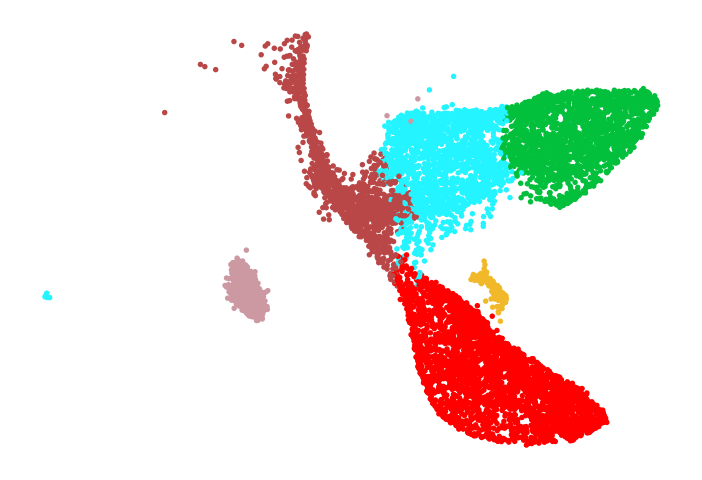

In [73]:
sc.pl.umap(adata_new_luminal, color='leiden_r1', size=30, legend_loc=None, 
           title = '', frameon=False,
           palette = mycolormap_luminal,
           show = True, legend_fontsize = 5, 
           save = 'adata_luminal_imputation2.pdf')

In [43]:
genes = fcHurdleSig_1vs2['gene_id'].tolist()
genes.remove("hETV4")

In [44]:
genes[0:0]=['ETV4AAA','ETV4WT','EYFP']

In [45]:
genes[0:10]

['ETV4AAA',
 'ETV4WT',
 'EYFP',
 'Pyy',
 'Dusp6',
 'Tgfb1',
 'Lcn2',
 'Ly6a',
 'Ctsh',
 'Gm12840']

In [46]:
genes.remove('Gsn')

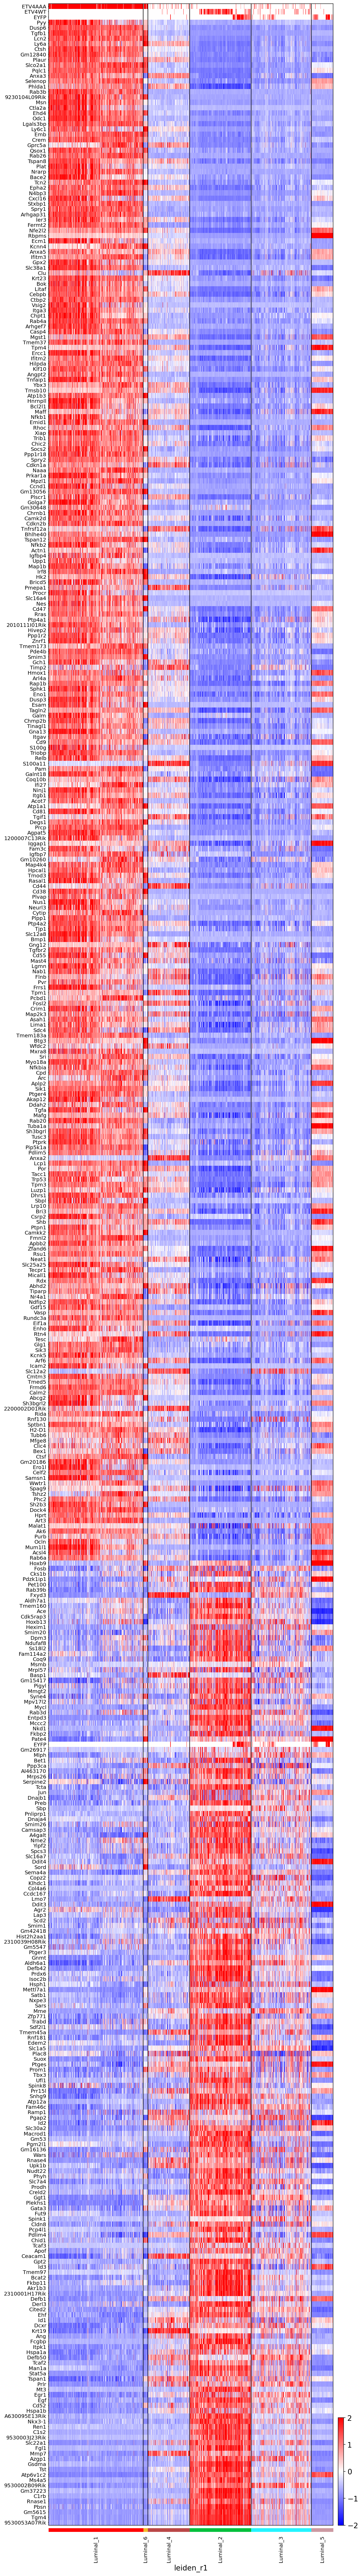

In [79]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(adata_new_luminal, genes, groupby='leiden_r1', 
              use_raw=False,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Luminal_imputation_fcHurdleSig_1vs2.pdf")

In [47]:
fcHurdle_1vs2

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr
1       p00001   0.000000e+00 -4.759130 -4.523703 -4.994558   0.000000e+00
2       p00002   7.235509e-04  0.077563  0.297215 -0.142089   1.386480e-03
3       p00003   1.639231e-19  0.220208  0.285953  0.154463   8.423600e-19
4       p00004  1.864712e-152  2.517591  2.782619  2.252563  6.878919e-151
5       p00005   6.006554e-07  0.002904  0.129300 -0.123491   1.531158e-06
...        ...            ...       ...       ...       ...            ...
18773   p19850   8.553106e-01       NaN       NaN       NaN   8.950160e-01
18774   p19851   4.387888e-01 -0.007396  0.003906 -0.018698   5.176313e-01
18775   p19852   4.296706e-26  1.002891  1.211595  0.794187   2.781084e-25
18776   p19853   4.799975e-12  0.817081  1.055806  0.578357   1.740281e-11
18777   p19854   2.507251e-03 -0.120333 -0.054106 -0.186560   4.529842e-03

[18777 rows x 6 columns]

In [48]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle_1vs2, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * sign(FC)

In [49]:
fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321

<ipython-input-49-3ab27d3432d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321


In [56]:
#luminal_1_vs_luminal_2
fcHurdle_genes['score'] = np.log10(fcHurdle_genes['fdr']) * np.sign(fcHurdle_genes['coef'])
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00001    0.000000 -4.759130 -4.523703 -4.994558  9.980126e-322   
2       p00092    0.000000 -3.416081 -3.202350 -3.629812  9.980126e-322   
3       p00554    0.000000 -4.645395 -4.457379 -4.833411  9.980126e-322   
4       p00607    0.000000 -4.445860 -4.289522 -4.602197  9.980126e-322   
5       p00691    0.000000  6.487462  6.782688  6.192236  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18773   p04159    1.000000       NaN       NaN       NaN   1.000000e+00   
18774   p07724    1.000000       NaN       NaN       NaN   1.000000e+00   
18775   p09923    1.000000       NaN       NaN       NaN   1.000000e+00   
18776   p16253    1.000000       NaN       NaN       NaN   1.000000e+00   
18777   p17846    0.999826  0.000033  0.005009 -0.004944   1.000000e+00   

             gene_id  n_cells  highly_variable     means  dispersions  \
1              hETV4     9304                1  0.245906     1.427165   
2             Ptp4a1    34605                0  0.828624     0.627926   
3                Bok    10790                0  0.203527     1.013942   
4             Tmem37     4279                0  0.067452     0.950479   
5               Ren1     4674                1  0.140515     2.778706   
...              ...      ...              ...       ...          ...   
18773          Pitx2      205                0  0.003149     0.900341   
18774        Gm28523       36                0  0.000415     0.669675   
18775        Gm16105       13                0  0.000192     0.943364   
18776        Gm10425       15                0  0.000187     0.911859   
18777  A930024N18Rik       55                0  0.000652     0.787292   

       dispersions_norm      mean       std       score  
1              8.125310  0.245906  0.592409  321.000864  
2              0.474700  0.828624  0.721328  321.000864  
3              3.626762  0.203527  0.454273  321.000864  
4              2.413399  0.067452  0.253202  321.000864  
5             25.528439  0.140515  0.624859 -321.000864  
...                 ...       ...       ...         ...  
18773          0.576918  0.003149  0.053244         NaN  
18774         -1.116722  0.000415  0.016670         NaN  
18775          0.760662  0.000192  0.013453         NaN  
18776          0.588395  0.000187  0.013054         NaN  
18777         -0.321062  0.000652  0.022653    0.000000  

[18777 rows x 15 columns]

In [57]:
fcHurdle_genes.sort_values(by=['score'])
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00001    0.000000 -4.759130 -4.523703 -4.994558  9.980126e-322   
2       p00092    0.000000 -3.416081 -3.202350 -3.629812  9.980126e-322   
3       p00554    0.000000 -4.645395 -4.457379 -4.833411  9.980126e-322   
4       p00607    0.000000 -4.445860 -4.289522 -4.602197  9.980126e-322   
5       p00691    0.000000  6.487462  6.782688  6.192236  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18773   p04159    1.000000       NaN       NaN       NaN   1.000000e+00   
18774   p07724    1.000000       NaN       NaN       NaN   1.000000e+00   
18775   p09923    1.000000       NaN       NaN       NaN   1.000000e+00   
18776   p16253    1.000000       NaN       NaN       NaN   1.000000e+00   
18777   p17846    0.999826  0.000033  0.005009 -0.004944   1.000000e+00   

             gene_id  n_cells  highly_variable     means  dispersions  \
1              hETV4     9304                1  0.245906     1.427165   
2             Ptp4a1    34605                0  0.828624     0.627926   
3                Bok    10790                0  0.203527     1.013942   
4             Tmem37     4279                0  0.067452     0.950479   
5               Ren1     4674                1  0.140515     2.778706   
...              ...      ...              ...       ...          ...   
18773          Pitx2      205                0  0.003149     0.900341   
18774        Gm28523       36                0  0.000415     0.669675   
18775        Gm16105       13                0  0.000192     0.943364   
18776        Gm10425       15                0  0.000187     0.911859   
18777  A930024N18Rik       55                0  0.000652     0.787292   

       dispersions_norm      mean       std       score  
1              8.125310  0.245906  0.592409  321.000864  
2              0.474700  0.828624  0.721328  321.000864  
3              3.626762  0.203527  0.454273  321.000864  
4              2.413399  0.067452  0.253202  321.000864  
5             25.528439  0.140515  0.624859 -321.000864  
...                 ...       ...       ...         ...  
18773          0.576918  0.003149  0.053244         NaN  
18774         -1.116722  0.000415  0.016670         NaN  
18775          0.760662  0.000192  0.013453         NaN  
18776          0.588395  0.000187  0.013054         NaN  
18777         -0.321062  0.000652  0.022653    0.000000  

[18777 rows x 15 columns]

In [58]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

primerid     Pr(>Chisq)  coef  ci.hi  ci.lo            fdr  gene_id  \
276     p03674  1.040051e-227   NaN    NaN    NaN  7.075739e-226     Bcan   
371     p05570  2.696978e-191   NaN    NaN    NaN  1.364991e-189   Sema3a   
960     p06310   3.107926e-87   NaN    NaN    NaN   6.078909e-86  Gm43342   
1085    p14855   4.409306e-76   NaN    NaN    NaN   7.630741e-75     Amph   
1181    p16970   1.480271e-70   NaN    NaN    NaN   2.353518e-69  Ccdc184   
...        ...            ...   ...    ...    ...            ...      ...   
18772   p03822   1.000000e+00   NaN    NaN    NaN   1.000000e+00  Gm38411   
18773   p04159   1.000000e+00   NaN    NaN    NaN   1.000000e+00    Pitx2   
18774   p07724   1.000000e+00   NaN    NaN    NaN   1.000000e+00  Gm28523   
18775   p09923   1.000000e+00   NaN    NaN    NaN   1.000000e+00  Gm16105   
18776   p16253   1.000000e+00   NaN    NaN    NaN   1.000000e+00  Gm10425   

       n_cells  highly_variable     means  dispersions  dispersions_norm  \
276       1246                0  0.020356     1.007607          2.069460   
371       1485                0  0.017263     0.778144         -0.143291   
960        211                0  0.002471     0.801170         -0.259394   
1085       640                0  0.006027     0.636150         -1.721289   
1181       587                0  0.008375     1.012483          1.399429   
...        ...              ...       ...          ...               ...   
18772       25                0  0.000209     0.645414         -0.868484   
18773      205                0  0.003149     0.900341          0.576918   
18774       36                0  0.000415     0.669675         -1.116722   
18775       13                0  0.000192     0.943364          0.760662   
18776       15                0  0.000187     0.911859          0.588395   

           mean       std  score  
276    0.020356  0.143217    NaN  
371    0.017263  0.115900    NaN  
960    0.002471  0.044492    NaN  
1085   0.006027  0.061922    NaN  
1181   0.008375  0.092083    NaN  
...         ...       ...    ...  
18772  0.000209  0.011615    NaN  
18773  0.003149  0.053244    NaN  
18774  0.000415  0.016670    NaN  
18775  0.000192  0.013453    NaN  
18776  0.000187  0.013054    NaN  

[2541 rows x 15 columns]

In [59]:
fcHurdle_genes.to_csv('./MAST/luminal1vs2/fcHurdle_genes.csv')

#### Luminal 1 vs Luminal 6

In [12]:
adata_normalized_CPM_log2.obs['leiden_r1']

AAACCTGGTGAGTGAC           Macrophage_2
AAATGCCAGAAGATTC           Macrophage_2
AAGACCTGTGAAAGAG              T_cells_1
AATCCAGAGAGGTAGA          Fibroblasts_2
ACACCAAAGCGTGAGT           Macrophage_2
                            ...        
CTCGTCAGTAGAGTGC           Macrophage_2
ATCCGAAAGGTGTGGT-1    Seminal_vesicle_1
CCCAGTTAGGTACTCT      Seminal_vesicle_1
TGCGTGGAGTGGTCCC              Luminal_4
CGTCACTCAAGCTGGA              Luminal_4
Name: leiden_r1, Length: 48926, dtype: category
Categories (25, object): ['Basal_1', 'Fibroblasts_1', 'Basal_2', 'Basal_3', ..., 'Macrophage_3', 'Nerve_cells', 'Luminal_6', 'Seminal_vesicle_2']

In [13]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_6vs1 <- subset(sca, with(colData(sca), leiden_r1 %in% c('Luminal_1','Luminal_6')))
head(sca_6vs1)

class: SingleCellAssay 
dim: 6 3402 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(3402): wk11426 wk23441 ... wk48909 wk48910
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [14]:
%%R
str(colData(sca_6vs1))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:3402] "wk11426" "wk23441" "wk23445" "wk23450" ...
  ..@ nrows          : int 3402
  ..@ listData       :List of 16
  .. ..$ cells        : chr [1:3402] "TAAGTGCAGAAACGCC" "AACTCCCGTCCTGCTT" "ACAGCTACACGACTCG" "ACTATCTTCTGATTCT" ...
  .. ..$ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 3 1 1 1 1 1 1 1 1 1 ...
  .. ..$ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 8 levels "TY_2weeks","TY_4months",..: 3 5 5 5 5 5 5 5 5 5 ...
  .. ..$ n_counts     : num [1:3402] 17782 3171 2938 4522 1933 ...
  .. ..$ log_counts   : num [1:3402] 9.81 8.12 8.03 8.5 7.67 ...
  .. ..$ n_genes      : int [1:3402] 3591 1614 1154 1716 962 2274 1736 2050 1656 4022 ...
  .. ..$ mt_frac      : num [1:3402] 0.028 0.0604 0.0433 0.0815 0.0967 ...
  .. ..$ doublet      : num [1:3402

In [15]:
%%R
head(rowData(sca_6vs1))

       gene_id n_cells highly_variable       means dispersions dispersions_norm
p00001   hETV4    9304               1 0.245906325   1.4271647        8.1253099
p00002    EGFP   10407               0 0.153405170   0.8349393        1.4996085
p00003 CreERT2     163               0 0.003174699   1.2363847        3.4107995
p00004    EYFP    6591               1 0.261973219   2.5312355       19.7636814
p00005   hETV4     720               0 0.010206114   1.1866987        3.1457226
p00006    Xkr4      18               0 0.000189229   0.6379560       -0.9092633
              mean        std primerid
p00001 0.245906325 0.59240934   p00001
p00002 0.153405170 0.35788825   p00002
p00003 0.003174699 0.06265101   p00003
p00004 0.261973219 0.81431930   p00004
p00005 0.010206114 0.11005263   p00005
p00006 0.000189229 0.01098726   p00006


In [16]:
%%R
levels(colData(sca_6vs1)$leiden_r1)

 [1] "Basal_1"           "Fibroblasts_1"     "Basal_2"          
 [4] "Basal_3"           "Luminal_1"         "Fibroblasts_2"    
 [7] "Fibroblasts_3"     "Macrophage_1"      "Seminal_vesicle_1"
[10] "Luminal_2"         "Luminal_3"         "T_cells_1"        
[13] "Macrophage_2"      "Endothelial"       "Fibroblasts_4"    
[16] "Luminal_4"         "Dendritic_cells"   "Basal_4"          
[19] "T_cells_2"         "Luminal_5"         "Fibroblasts_5"    
[22] "Macrophage_3"      "Nerve_cells"       "Luminal_6"        
[25] "Seminal_vesicle_2"


In [17]:
%%R
levels(droplevels(colData(sca_6vs1)$leiden_r1))

[1] "Luminal_1" "Luminal_6"


In [18]:
%%R
colData(sca_6vs1)$leiden_r1 <- as.factor(as.character(colData(sca_6vs1)$leiden_r1))

In [19]:
%%R
levels(colData(sca_6vs1)$leiden_r1)

[1] "Luminal_1" "Luminal_6"


In [20]:
%%R
print("Dimensions before subsetting:")
print(dim(sca_6vs1))
# filter out the not expressed genes
sca_6vs1_filt = sca_6vs1[rowSums(assay(sca_6vs1)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_6vs1_filt))

[1] "Dimensions before subsetting:"
[1] 19854  3402
[1] "Dimensions after subsetting:"
[1] 18321  3402


In [21]:
%%R
levels(colData(sca_6vs1_filt)$leiden_r1)

[1] "Luminal_1" "Luminal_6"


In [22]:
%%R
save(sca_6vs1_filt, file="./MAST/sca_6vs1_filt.rda")

In [23]:
%%R
colData(sca_6vs1_filt)$n_genes = scale(colData(sca_6vs1_filt)$n_genes)

In [24]:
%%R
mean(colData(sca_6vs1_filt)$n_genes)

[1] 2.941667e-16


In [25]:
%%R
sd(colData(sca_6vs1_filt)$n_genes)

[1] 1


In [26]:
%%R
head(colData(sca_6vs1_filt)$n_genes)

           [,1]
[1,]  0.0712659
[2,] -1.7705747
[3,] -2.1991264
[4,] -1.6755480
[5,] -2.3780001
[6,] -1.1556962


In [27]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_6vs1 <- zlm(formula = ~leiden_r1 + n_genes, sca=sca_6vs1_filt, method = "glm")
zlmCond_6vs1

Fitted zlm on 18321 genes and 3402 cells.
 Using GLMlike ~ leiden_r1 + n_genes 


In [28]:
%%R
summary_6vs1 <- summary(zlmCond_6vs1, logFC = TRUE, doLRT = 'leiden_r1Luminal_6')
summary_6vs1

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid leiden_r1Luminal_6 n_genes
 p02488     81.9*               7.8 
 p06275     -0.1               26.9*
 p07737     53.5*               3.8 
 p15348      1.0               24.7*


In [29]:
%%R
save(summary_6vs1, file="./MAST/luminal6vs1/summary_6vs1.rda")

In [30]:
%%R
load("./MAST/luminal6vs1/summary_6vs1.rda")

In [31]:
%%R
head(summary_6vs1$datatable)

  primerid component           contrast  Pr(>Chisq)       ci.hi      ci.lo
1   p00001         C leiden_r1Luminal_6 0.003736531 -0.07193486 -0.3687597
2   p00001         C        (Intercept)          NA  9.58031693  9.5170520
3   p00001         C            n_genes          NA -0.31206825 -0.3756447
4   p00001         D leiden_r1Luminal_6 0.261305612  0.34399489 -1.4159017
5   p00001         D        (Intercept)          NA  5.32803923  4.4453146
6   p00001         D            n_genes          NA  1.58264332  1.0564121
        coef          z
1 -0.2203473  -2.909950
2  9.5486845 591.641271
3 -0.3438565 -21.201139
4 -0.5359534  -1.193763
5  4.8866769  21.700338
6  1.3195277   9.829241


In [32]:
%%R
summaryDt = summary_6vs1$datatable
head(summaryDt)

  primerid component           contrast  Pr(>Chisq)       ci.hi      ci.lo
1   p00001         C leiden_r1Luminal_6 0.003736531 -0.07193486 -0.3687597
2   p00001         C        (Intercept)          NA  9.58031693  9.5170520
3   p00001         C            n_genes          NA -0.31206825 -0.3756447
4   p00001         D leiden_r1Luminal_6 0.261305612  0.34399489 -1.4159017
5   p00001         D        (Intercept)          NA  5.32803923  4.4453146
6   p00001         D            n_genes          NA  1.58264332  1.0564121
        coef          z
1 -0.2203473  -2.909950
2  9.5486845 591.641271
3 -0.3438565 -21.201139
4 -0.5359534  -1.193763
5  4.8866769  21.700338
6  1.3195277   9.829241


In [33]:
%%R
fcHurdle_6vs1 <- merge(summaryDt[contrast=='leiden_r1Luminal_6' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='leiden_r1Luminal_6' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [34]:
%%R -o fcHurdle_6vs1
head(fcHurdle_6vs1[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid  Pr(>Chisq)       coef       ci.hi     ci.lo         fdr
1   p00001 0.007948919 -0.2676083 -0.08980965 -0.445407 0.039746763
2   p00002 0.000421311 -0.8070151 -0.31296177 -1.301068 0.003080143
3   p00003 0.592662502        NaN         NaN       NaN 0.834717493
4   p00004 0.721250167        NaN         NaN       NaN 0.885176852
5   p00005 0.668619772  0.1445482  0.48637941 -0.197283 0.863633872
6   p00006 0.847219766        NaN         NaN       NaN 0.917316550


In [35]:
fcHurdle_6vs1.to_csv('./MAST/luminal6vs1/fcHurdle_6vs1.csv')

In [36]:
%%R -o fcHurdleSig_6vs1
library(data.table)
fcHurdleSig_6vs1 <- merge(fcHurdle_6vs1[fdr<.05 & abs(coef)>log2(5.0)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig_6vs1, fdr)

In [37]:
fcHurdleSig_6vs1.sort_values(by=['coef'], axis=0, ascending=True, inplace=True)

In [38]:
fcHurdleSig_6vs1

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
13   p16951  4.753168e-135 -7.538043 -7.237326 -7.838759  5.805519e-132   
15   p10388  1.112365e-121 -6.978857 -6.516508 -7.441206  1.132203e-118   
22   p06048  2.197977e-107 -6.886949 -6.414114 -7.359784  1.491449e-104   
58   p04844   1.319711e-61 -5.855685 -5.491319 -6.220051   3.454060e-59   
59   p03873   2.203971e-59 -5.746212 -5.344495 -6.147929   5.687177e-57   
..      ...            ...       ...       ...       ...            ...   
10   p01624  7.176949e-139  6.620233  7.152820  6.087647  1.095741e-135   
5    p10946  7.372776e-183  6.974701  7.424282  6.525120  2.701533e-179   
4    p08269  7.507743e-188  7.364287  7.756191  6.972382  3.438734e-184   
3    p02488  8.285325e-266  8.891420  9.104211  8.678630  5.059848e-262   
1    p07737  3.192883e-295  9.216212  9.553790  8.878633  5.849682e-291   

    gene_id  n_cells  highly_variable     means  dispersions  \
13  Slc38a1     9544                0  0.188417     1.071426   
15     Gas6    31124                0  0.891158     0.934476   
22    Anxa3    23529                0  0.580194     0.901418   
58    Rab3b     3083                1  0.080953     1.730789   
59     Ecm1    22816                0  0.603042     1.106963   
..      ...      ...              ...       ...          ...   
10     Rprm     1018                0  0.013268     1.062727   
5     Ces1d     7357                0  0.130185     0.968464   
4       Hpn     2998                0  0.034450     0.796089   
3   Wfdc15b     5692                1  0.129105     1.843797   
1      Ldhb    10478                0  0.172278     0.978754   

    dispersions_norm      mean       std  
13          4.290329  0.188417  0.449305  
15          2.320395  0.891158  0.912560  
22          2.121358  0.580194  0.723186  
58         12.053261  0.080953  0.374315  
59          3.358923  0.603042  0.817035  
..               ...       ...       ...  
10          2.104591  0.013268  0.118743  
5           3.150241  0.130185  0.355077  
4           0.295864  0.034450  0.165606  
3          13.971095  0.129105  0.487897  
1           3.220576  0.172278  0.410631  

[321 rows x 14 columns]

In [39]:
fcHurdleSig_6vs1.to_csv('./MAST/luminal6vs1/fcHurdleSig_fdr005coef_1vs6.csv')

In [40]:
gene_list = fcHurdleSig_6vs1['gene_id']
gene_list.head()

13    Slc38a1
15       Gas6
22      Anxa3
58      Rab3b
59       Ecm1
Name: gene_id, dtype: category
Categories (19853, object): ['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik', ..., 'Zzef1', 'Zzz3', 'a', 'hETV4']

In [41]:
gene_list.str.upper()

13    SLC38A1
15       GAS6
22      ANXA3
58      RAB3B
59       ECM1
       ...   
10       RPRM
5       CES1D
4         HPN
3     WFDC15B
1        LDHB
Name: gene_id, Length: 321, dtype: object

In [42]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy as gp
names = gp.get_library_name(database='Mouse') # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [43]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
import os, sys
gmtfiles = os.listdir('./GSEA/gmt')

for i in gmtfiles:
    enr = gp.enrichr(gene_list=gene_list.str.upper(),
                     gene_sets= './GSEA/gmt/'+i,
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='luminal1_vs_luminal6',
                     outdir='./GSEA/luminal1_vs_luminal6/enrichr',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )

In [44]:
#Interpretation of differentially expressed genes in luminal2-3
gp = GProfiler(return_dataframe=True)
enrichment = gp.profile(organism='mmusculus', query=fcHurdleSig_6vs1['gene_id'].tolist())
enrichment

source       native                                               name  \
0    GO:BP   GO:0048856                   anatomical structure development   
1    GO:CC   GO:0005737                                          cytoplasm   
2    GO:BP   GO:0032502                              developmental process   
3    GO:BP   GO:0048731                                 system development   
4    GO:BP   GO:0007275                 multicellular organism development   
..     ...          ...                                                ...   
454     TF    TF:M02023                 Factor: MAZ; motif: NKGGGAGGGGRGGR   
455  GO:CC   GO:0043235                                   receptor complex   
456  GO:BP   GO:0044419  biological process involved in interspecies in...   
457     TF  TF:M00470_1  Factor: AP-2gamma; motif: GCCYNNGGS; match cla...   
458     TF    TF:M03567                Factor: Sp2; motif: NYSGCCCCGCCCCCY   

          p_value  significant  \
0    6.584796e-24         True   
1    1.741012e-23         True   
2    2.858243e-22         True   
3    4.531720e-22         True   
4    2.372574e-20         True   
..            ...          ...   
454  4.816103e-02         True   
455  4.828464e-02         True   
456  4.907346e-02         True   
457  4.930998e-02         True   
458  4.949890e-02         True   

                                           description  term_size  query_size  \
0    "The biological process whose specific outcome...       6113         298   
1    "The contents of a cell excluding the plasma m...      11347         304   
2    "A biological process whose specific outcome i...       6768         298   
3    "The process whose specific outcome is the pro...       5090         298   
4    "The biological process whose specific outcome...       5441         298   
..                                                 ...        ...         ...   
454                 Factor: MAZ; motif: NKGGGAGGGGRGGR       7967         306   
455  "Any protein complex that undergoes combinatio...        385         304   
456  "Any process evolved to enable an interaction ...       1851         298   
457  Factor: AP-2gamma; motif: GCCYNNGGS; match cla...       3417         306   
458                Factor: Sp2; motif: NYSGCCCCGCCCCCY       6432         306   

     intersection_size  effective_domain_size  precision    recall    query  \
0                  151                  27492   0.506711  0.024701  query_1   
1                  217                  27279   0.713816  0.019124  query_1   
2                  157                  27492   0.526846  0.023197  query_1   
3                  133                  27492   0.446309  0.026130  query_1   
4                  135                  27492   0.453020  0.024812  query_1   
..                 ...                    ...        ...       ...      ...   
454                146                  21833   0.477124  0.018326  query_1   
455                 14                  27279   0.046053  0.036364  query_1   
456                 40                  27492   0.134228  0.021610  query_1   
457                 75                  21833   0.245098  0.021949  query_1   
458                123                  21833   0.401961  0.019123  query_1   

                      parents  
0                [GO:0032502]  
1    [GO:0005622, GO:0110165]  
2                [GO:0008150]  
3    [GO:0007275, GO:0048856]  
4    [GO:0032501, GO:0048856]  
..                        ...  
454               [TF:M00000]  
455              [GO:0032991]  
456              [GO:0008150]  
457               [TF:M00470]  
458               [TF:M00000]  

[459 rows x 14 columns]

In [45]:
#enrich_results = paneth_enrichment.sort_values('p.value').iloc[:,[2,3,5,6,11]]
enrich_results = enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]

In [46]:
pd.set_option("display.max_colwidth", 800)
enrich_results.to_csv('./GSEA/enrich_results_luminal1_vs_luminal6.csv')
enrich_results

p_value  term_size  intersection_size    recall  \
native                                                              
GO:0048856   6.584796e-24       6113                151  0.024701   
GO:0005737   1.741012e-23      11347                217  0.019124   
GO:0032502   2.858243e-22       6768                157  0.023197   
GO:0048731   4.531720e-22       5090                133  0.026130   
GO:0007275   2.372574e-20       5441                135  0.024812   
...                   ...        ...                ...       ...   
TF:M02023    4.816103e-02       7967                146  0.018326   
GO:0043235   4.828464e-02        385                 14  0.036364   
GO:0044419   4.907346e-02       1851                 40  0.021610   
TF:M00470_1  4.930998e-02       3417                 75  0.021949   
TF:M03567    4.949890e-02       6432                123  0.019123   

                                                                                  name  
native                                                                                  
GO:0048856                                            anatomical structure development  
GO:0005737                                                                   cytoplasm  
GO:0032502                                                       developmental process  
GO:0048731                                                          system development  
GO:0007275                                          multicellular organism development  
...                                                                                ...  
TF:M02023                                           Factor: MAZ; motif: NKGGGAGGGGRGGR  
GO:0043235                                                            receptor complex  
GO:0044419   biological process involved in interspecies interaction between organisms  
TF:M00470_1                        Factor: AP-2gamma; motif: GCCYNNGGS; match class: 1  
TF:M03567                                          Factor: Sp2; motif: NYSGCCCCGCCCCCY  

[459 rows x 5 columns]

In [47]:
# luminal 1,6,4,2,3,5
mycolormap_luminal = ["red", "#f1b929", "#ba4747", "#03c03c", "#24F4FF", "#cc99a2"]

In [48]:
import pickle

# Getting back the objects:
with open('adata_new_luminal2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata_new_luminal = pickle.load(f)

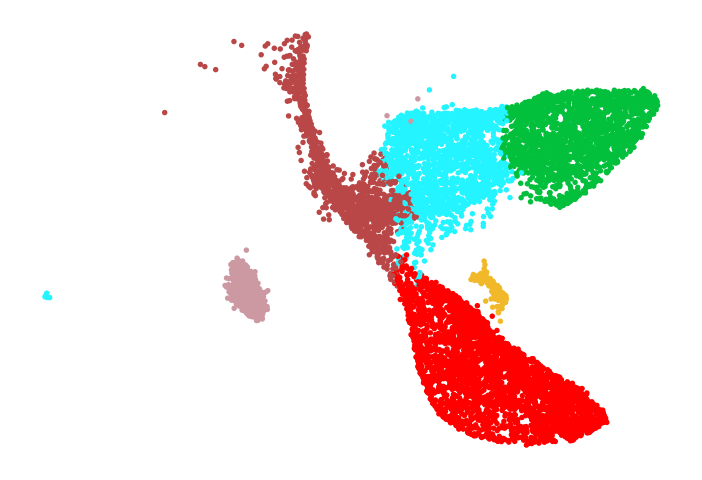

In [49]:
sc.pl.umap(adata_new_luminal, color='leiden_r1', size=30, legend_loc=None, 
           title = '', frameon=False,
           palette = mycolormap_luminal,
           show = True, legend_fontsize = 5, 
           save = 'adata_luminal_imputation2.pdf')

In [ ]:
genes = fcHurdleSig_6vs1['gene_id'].tolist()
genes.remove("hETV4")

In [44]:
genes[0:0]=['ETV4AAA','ETV4WT','EYFP']

In [45]:
genes[0:10]

['ETV4AAA',
 'ETV4WT',
 'EYFP',
 'Pyy',
 'Dusp6',
 'Tgfb1',
 'Lcn2',
 'Ly6a',
 'Ctsh',
 'Gm12840']

In [46]:
genes.remove('Gsn')

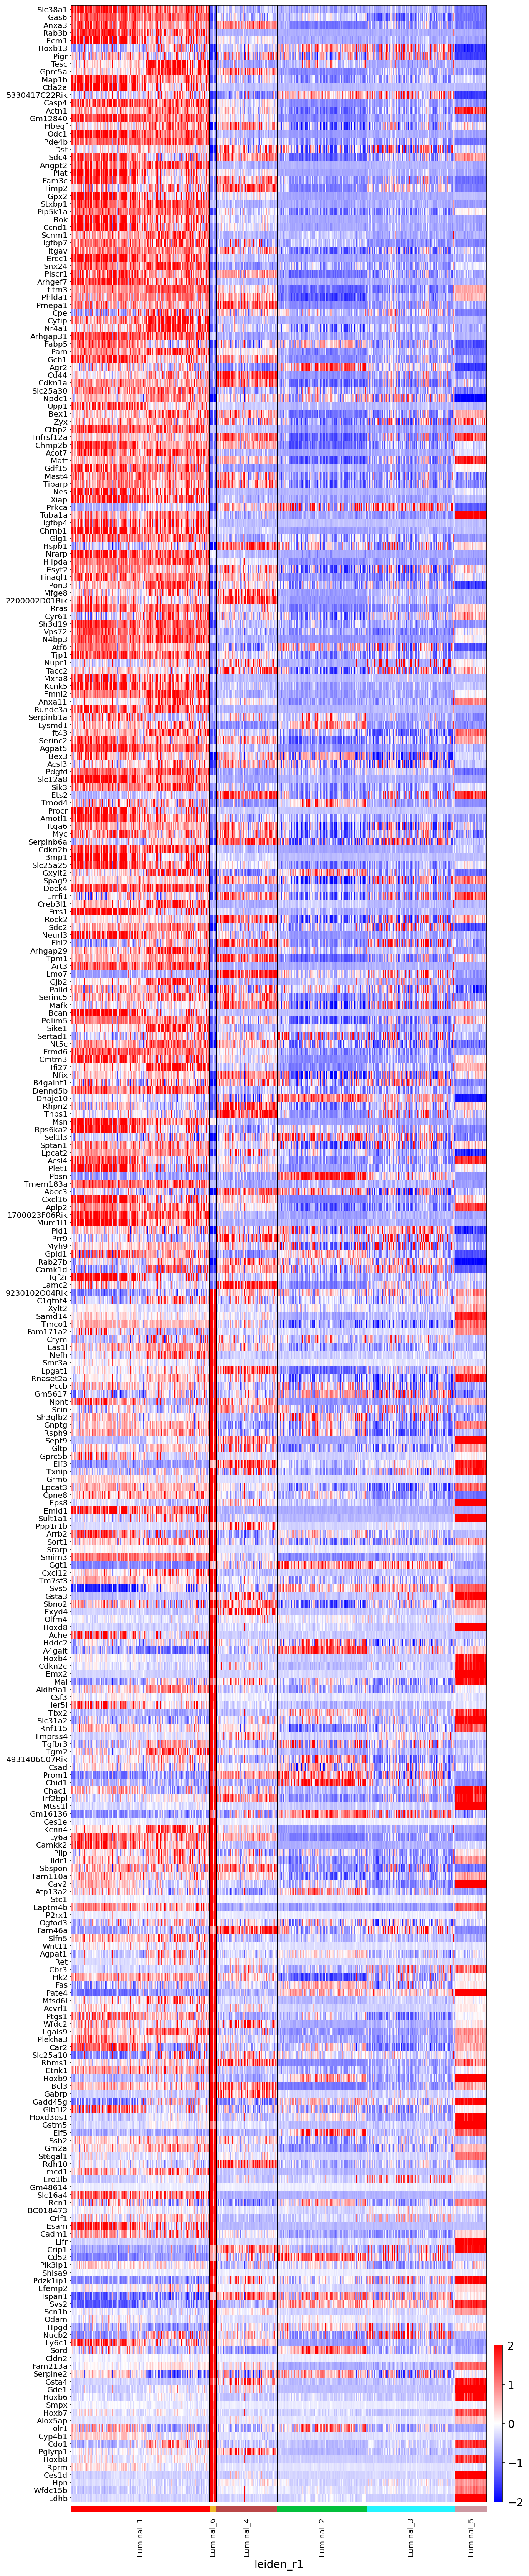

In [51]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(adata_new_luminal, genes, groupby='leiden_r1', 
              use_raw=False,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Luminal_imputation_fcHurdleSig_1vs6.pdf")

### basal compare

In [87]:
%%R
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [88]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_basal_1vs2 <- subset(sca, with(colData(sca), leiden_r1 %in% c('Basal_1','Basal_2')))
head(sca_basal_1vs2)

class: SingleCellAssay 
dim: 6 10270 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(10270): wk00020 wk00124 ... wk48878 wk48883
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [89]:
%%R
str(colData(sca_basal_1vs2))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:10270] "wk00020" "wk00124" "wk00125" "wk00132" ...
  ..@ nrows          : int 10270
  ..@ listData       :List of 16
  .. ..$ cells        : chr [1:10270] "AGCGGTCAGACTGTAA" "AAACGGGAGTTGAGAT" "AAACGGGTCCACGAAT" "AACCATGGTGGTAACG" ...
  .. ..$ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 4 4 4 4 4 4 4 4 4 4 ...
  .. ..$ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 8 levels "TY_2weeks","EWT_2weeks",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:10270] 2640 9467 4714 5045 4140 ...
  .. ..$ log_counts   : num [1:10270] 7.9 9.17 8.48 8.54 8.38 ...
  .. ..$ n_genes      : int [1:10270] 1141 2329 1737 1771 1628 1759 1958 1333 1642 1481 ...
  .. ..$ mt_frac      : num [1:10270] 0.0248 0.0129 0.0222 0.0185 0.0511 ...
  .. ..$ doublet      : num

In [90]:
%%R
head(rowData(sca_basal_1vs2))

       gene_id n_cells highly_variable       means dispersions dispersions_norm
p00001   hETV4    9304               1 0.245906325   1.4271647        8.1253099
p00002    EGFP   10407               0 0.153405170   0.8349393        1.4996085
p00003 CreERT2     163               0 0.003174699   1.2363847        3.4107995
p00004    EYFP    6591               1 0.261973219   2.5312355       19.7636814
p00005   hETV4     720               0 0.010206114   1.1866987        3.1457226
p00006    Xkr4      18               0 0.000189229   0.6379560       -0.9092633
              mean        std primerid
p00001 0.245906325 0.59240934   p00001
p00002 0.153405170 0.35788825   p00002
p00003 0.003174699 0.06265101   p00003
p00004 0.261973219 0.81431930   p00004
p00005 0.010206114 0.11005263   p00005
p00006 0.000189229 0.01098726   p00006


In [91]:
%%R
levels(colData(sca_basal_1vs2)$leiden_r1)

 [1] "Basal_1"           "Fibroblasts_1"     "Basal_2"          
 [4] "Basal_3"           "Luminal_1"         "Fibroblasts_2"    
 [7] "Fibroblasts_3"     "Macrophage_1"      "Seminal_vesicle_1"
[10] "Luminal_2"         "Luminal_3"         "T_cells_1"        
[13] "Macrophage_2"      "Endothelial"       "Fibroblasts_4"    
[16] "Luminal_4"         "Dendritic_cells"   "Basal_4"          
[19] "T_cells_2"         "Luminal_5"         "Fibroblasts_5"    
[22] "Macrophage_3"      "Nerve_cells"       "Luminal_6"        
[25] "Seminal_vesicle_2"


In [92]:
%%R
levels(droplevels(colData(sca_basal_1vs2)$leiden_r1))

[1] "Basal_1" "Basal_2"


In [93]:
%%R
colData(sca_basal_1vs2)$leiden_r1 <- as.factor(as.character(colData(sca_basal_1vs2)$leiden_r1))

In [94]:
%%R
levels(colData(sca_basal_1vs2)$leiden_r1)

[1] "Basal_1" "Basal_2"


In [95]:
%%R
print("Dimensions before subsetting:")
print(dim(sca_basal_1vs2))
# filter out the not expressed genes
sca_basal_1vs2_filt = sca_basal_1vs2[rowSums(assay(sca_basal_1vs2)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_basal_1vs2_filt))

[1] "Dimensions before subsetting:"
[1] 19854 10270
[1] "Dimensions after subsetting:"
[1] 18842 10270


In [96]:
%%R
levels(colData(sca_basal_1vs2_filt)$leiden_r1)

[1] "Basal_1" "Basal_2"


In [97]:
%%R
save(sca_basal_1vs2_filt, file="./MAST/sca_basal_1vs2_filt.rda")

In [98]:
%%R
colData(sca_basal_1vs2_filt)$n_genes = scale(colData(sca_basal_1vs2_filt)$n_genes)

In [99]:
%%R
mean(colData(sca_basal_1vs2_filt)$n_genes)

[1] -1.595283e-16


In [100]:
%%R
sd(colData(sca_basal_1vs2_filt)$n_genes)

[1] 1


In [101]:
%%R
head(colData(sca_basal_1vs2_filt)$n_genes)

           [,1]
[1,] -1.3206995
[2,]  0.3554713
[3,] -0.4797923
[4,] -0.4318211
[5,] -0.6335824
[6,] -0.4487521


In [102]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_1vs2 <- zlm(formula = ~leiden_r1 + n_genes, sca=sca_basal_1vs2_filt, method = "glm")
zlmCond_1vs2

Fitted zlm on 18842 genes and 10270 cells.
 Using GLMlike ~ leiden_r1 + n_genes 


In [103]:
%%R
summary_1vs2 <- summary(zlmCond_1vs2, logFC = TRUE, doLRT = 'leiden_r1Basal_2')
summary_1vs2

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid leiden_r1Basal_2 n_genes
 p02606    117.4*             9.3 
 p06275    -14.6             49.6*
 p08045    103.8*            13.8 
 p15192     13.4             49.6*


In [104]:
%%R
save(summary_1vs2, file="./MAST/Basal_1vs2/summary_Basal_1vs2.rda")

In [105]:
%%R
head(summary_1vs2$datatable)

  primerid component         contrast   Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C leiden_r1Basal_2 5.514226e-07 -0.22339711 -0.50237428
2   p00001         C      (Intercept)           NA  7.71389210  7.62354385
3   p00001         C          n_genes           NA -0.68222086 -0.77625490
4   p00001         D leiden_r1Basal_2 1.104806e-72 -1.32574610 -1.69245075
5   p00001         D      (Intercept)           NA -1.38321712 -1.51295690
6   p00001         D          n_genes           NA  0.03685028 -0.09731717
         coef           z
1 -0.36288570  -5.0989325
2  7.66871798 332.7216995
3 -0.72923788 -30.3992045
4 -1.50909843 -16.1316667
5 -1.44808701 -43.7521678
6 -0.03023345  -0.8833211


In [106]:
%%R
summaryDt = summary_1vs2$datatable
head(summaryDt)

  primerid component         contrast   Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C leiden_r1Basal_2 5.514226e-07 -0.22339711 -0.50237428
2   p00001         C      (Intercept)           NA  7.71389210  7.62354385
3   p00001         C          n_genes           NA -0.68222086 -0.77625490
4   p00001         D leiden_r1Basal_2 1.104806e-72 -1.32574610 -1.69245075
5   p00001         D      (Intercept)           NA -1.38321712 -1.51295690
6   p00001         D          n_genes           NA  0.03685028 -0.09731717
         coef           z
1 -0.36288570  -5.0989325
2  7.66871798 332.7216995
3 -0.72923788 -30.3992045
4 -1.50909843 -16.1316667
5 -1.44808701 -43.7521678
6 -0.03023345  -0.8833211


In [107]:
%%R
fcHurdle_1vs2 <- merge(summaryDt[contrast=='leiden_r1Basal_2' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='leiden_r1Basal_2' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [108]:
%%R -o fcHurdle_1vs2
head(fcHurdle_1vs2[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid   Pr(>Chisq)          coef        ci.hi        ci.lo          fdr
1   p00001 8.989317e-77 -1.0984339849 -0.997694191 -1.199173779 1.426931e-75
2   p00002 3.347599e-20  0.4011016656  0.549888063  0.252315268 1.692847e-19
3   p00003 6.499561e-02 -0.0109066888 -0.002499808 -0.019313569 9.780747e-02
4   p00004 0.000000e+00 -3.2167549498 -3.093488308 -3.340021592 0.000000e+00
5   p00005 1.915882e-02 -0.0238352715 -0.009479526 -0.038191017 3.174101e-02
6   p00008 9.631015e-01  0.0008062388  0.009731044 -0.008118566 9.784729e-01


In [109]:
fcHurdle_1vs2.to_csv('./MAST/Basal_1vs2/fcHurdle_Basal_1vs2.csv')

In [128]:
%%R -o fcHurdleSig_1vs2
library(data.table)
fcHurdleSig_1vs2 <- merge(fcHurdle_1vs2[fdr<.05 & abs(coef)>log2(5)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig_1vs2, fdr)

In [129]:
fcHurdleSig_1vs2.sort_values(by=['coef'], axis=0, ascending=True, inplace=True)

In [130]:
fcHurdleSig_1vs2

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo  fdr gene_id  n_cells  \
116   p18869         0.0 -6.068534 -5.885842 -6.251226  0.0    Egr1    33184   
111   p18250         0.0 -5.479551 -5.286380 -5.672723  0.0  Hspa1a    29250   
9     p01164         0.0 -5.010314 -4.811747 -5.208881  0.0    Atf3    38344   
59    p10424         0.0 -4.949764 -4.722896 -5.176633  0.0  Defb50    28002   
30    p05226         0.0 -4.938763 -4.731339 -5.146186  0.0     Id3    34065   
..       ...         ...       ...       ...       ...  ...     ...      ...   
70    p12460         0.0  6.182502  6.345928  6.019075  0.0   Plet1    18884   
66    p11613         0.0  6.506994  6.677017  6.336970  0.0  Lgals3    26866   
83    p14346         0.0  7.014922  7.189785  6.840059  0.0   Krt19    19549   
45    p08045         0.0  7.117181  7.251579  6.982782  0.0   Plaur    21822   
18    p02606         0.0  7.283191  7.404769  7.161614  0.0  Pmepa1    21415   

     highly_variable     means  dispersions  dispersions_norm      mean  \
116                0  1.201623     1.102107          3.329684  1.201623   
111                1  1.001981     1.324506          4.668720  1.001981   
9                  0  1.364782     0.798500          1.501703  1.364782   
59                 1  1.080506     2.052848          9.053977  1.080506   
30                 0  1.222069     1.022934          2.852992  1.222069   
..               ...       ...          ...               ...       ...   
70                 1  0.508224     1.365327          4.914496  0.508224   
66                 0  0.822631     1.255632          4.254037  0.822631   
83                 1  0.661053     1.691228          6.876708  0.661053   
45                 0  0.645772     1.263895          4.303789  0.645772   
18                 0  0.492080     0.933552          2.314837  0.492080   

          std  
116  1.150790  
111  1.152011  
9    1.043924  
59   1.489334  
30   1.118077  
..        ...  
70   0.833002  
66   1.016327  
83   1.057351  
45   0.903431  
18   0.677778  

[302 rows x 14 columns]

In [131]:
fcHurdleSig_1vs2.to_csv('./MAST/Basal_1vs2/fcHurdleSig_fdr005coef_1vs2.csv')

In [132]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('./MAST/Basal_1vs2/fcHurdleSig_1vs2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(fcHurdleSig_1vs2, f)

In [ ]:
import pickle

# Getting back the objects:
with open('./MAST/luminal1vs2/fcHurdleSig_1vs2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    fcHurdleSig_1vs2 = pickle.load(f)

In [115]:
# luminal 1,6,4,2,3,5
mycolormap_basal = ["#966fd6", "#aec6cf", "#66cdaa", "#555f6d"]

In [116]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('adata_new_basal2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata_new_basal = pickle.load(f)

In [138]:
adata_new_basal.obs['leiden_r1'].cat.reorder_categories(['Basal_2','Basal_3','Basal_1','Basal_4'],inplace = True)

<ipython-input-138-127b0b040edd>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_new_basal.obs['leiden_r1'].cat.reorder_categories(['Basal_2','Basal_3','Basal_1','Basal_4'],inplace = True)


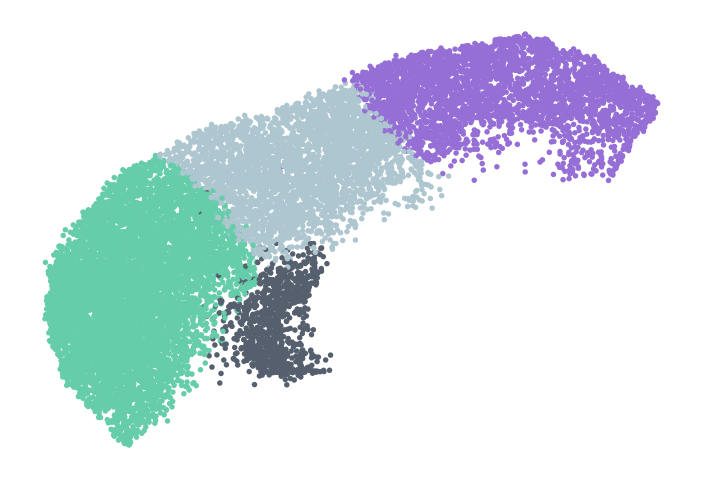

In [139]:
sc.pl.umap(adata_new_basal, color='leiden_r1', size=30, legend_loc=None, 
           title = '', frameon=False,
           palette = mycolormap_basal,
           show = True, legend_fontsize = 5, 
           save = 'adata_basal_imputation2.pdf')

In [133]:
adata_new_basal.var

2  n_cells  highly_variable     means  \
gene_id                                                               
ETV4AAA         Gene Expression   2234.0              1.0  0.245906   
EGFP            Gene Expression   7082.0              0.0  0.153405   
CreERT2         Gene Expression      5.0              0.0  0.003175   
EYFP            Gene Expression   6313.0              1.0  0.261973   
Mrpl15          Gene Expression   4965.0              0.0  0.135865   
...                         ...      ...              ...       ...   
AC168977.1      Gene Expression   4807.0              0.0  0.001918   
AC149090.1      Gene Expression    227.0              0.0  0.114098   
CAAA01118383.1  Gene Expression    874.0              0.0  0.158647   
CAAA01147332.1  Gene Expression   8071.0              0.0  0.017546   
ETV4WT                      NaN      NaN              NaN       NaN   

                dispersions  dispersions_norm      mean       std  
gene_id                                                            
ETV4AAA            1.427165          8.125310 -0.216104  0.199508  
EGFP               0.834939          1.499609  0.015744  0.168179  
CreERT2            1.236385          3.410800 -0.036781  0.010538  
EYFP               2.531236         19.763681  0.121069  0.504980  
Mrpl15             0.626101         -1.082051 -0.059063  0.188936  
...                     ...               ...       ...       ...  
AC168977.1         0.858370          0.165852 -0.001523  0.124494  
AC149090.1         0.929673          2.726850 -0.185180  0.073966  
CAAA01118383.1     0.676830         -0.454938 -0.077789  0.055485  
CAAA01147332.1     0.746338         -0.450005  0.012064  0.065128  
ETV4WT                  NaN               NaN       NaN       NaN  

[17289 rows x 8 columns]

In [141]:
genes = fcHurdleSig_1vs2['gene_id'].tolist()
len(genes)

302

In [142]:
genes.remove('EYFP')

In [143]:
genes[0:0]=['ETV4AAA','ETV4WT','EYFP']

In [144]:
genes[0:10]

['ETV4AAA',
 'ETV4WT',
 'EYFP',
 'Egr1',
 'Hspa1a',
 'Atf3',
 'Defb50',
 'Id3',
 'Adm',
 'Fos']

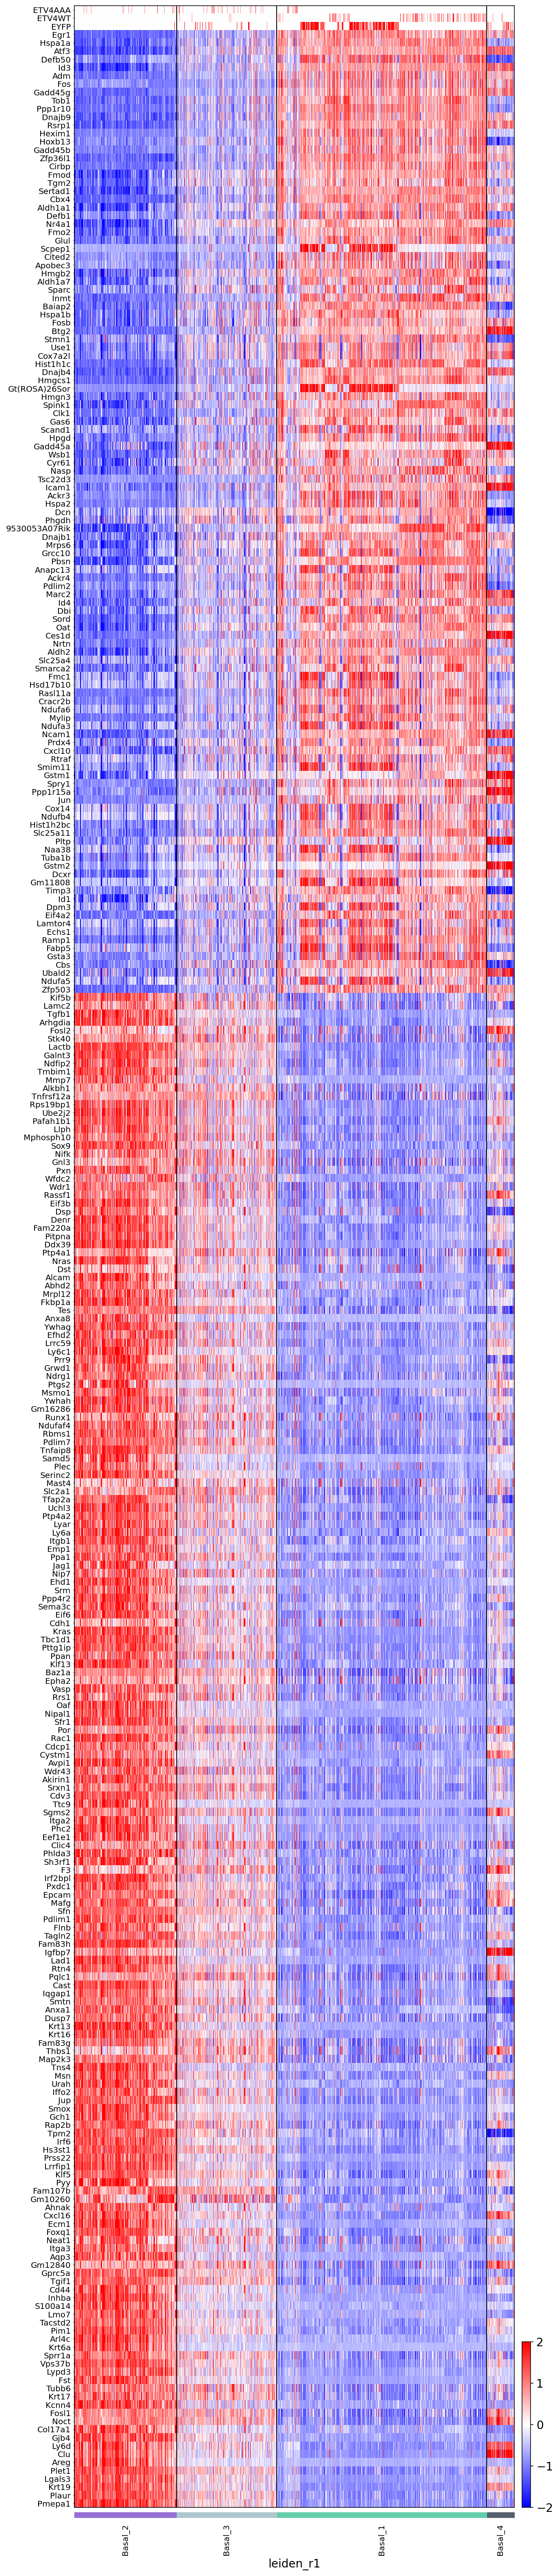

In [145]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(adata_new_basal, genes, groupby='leiden_r1', 
              use_raw=False,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Basal_imputation_fcHurdleSig_1vs2.pdf")

In [146]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle_1vs2, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * logFC

In [147]:
np.min(fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] > 0.0])

4.734784e-318

In [148]:
fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321

<ipython-input-148-3ab27d3432d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321


In [150]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * fcHurdle_genes['coef']
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00004    0.000000 -3.216755 -3.093488 -3.340022  9.980126e-322   
2       p00342    0.000000 -0.648730 -0.618398 -0.679063  9.980126e-322   
3       p00490    0.000000  4.398571  4.585234  4.211909  9.980126e-322   
4       p00506    0.000000  3.672770  3.850894  3.494646  9.980126e-322   
5       p00608    0.000000 -2.776819 -2.584369 -2.969268  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18838   p10802    1.000000       NaN       NaN       NaN   1.000000e+00   
18839   p11446    1.000000       NaN       NaN       NaN   1.000000e+00   
18840   p17181    1.000000       NaN       NaN       NaN   1.000000e+00   
18841   p18372    1.000000       NaN       NaN       NaN   1.000000e+00   
18842   p18914    0.999512 -0.000069  0.003614 -0.003753   1.000000e+00   

             gene_id  n_cells  highly_variable     means  dispersions  \
1               EYFP     6591                1  0.261973     2.531236   
2             Rpl37a    49610                0  3.306621     0.131675   
3              Arl4c    12969                1  0.267955     1.094052   
4            Lrrfip1    18431                0  0.316691     0.783708   
5                Dbi    37395                0  0.977997     0.591779   
...              ...      ...              ...       ...          ...   
18838  1700011L22Rik       11                0  0.000132     0.967052   
18839        Gm47814       24                0  0.000285     0.948229   
18840         Rbfox1       75                0  0.000982     0.813865   
18841         Ptchd4       93                0  0.001497     0.952641   
18842         Pcdhb5      140                0  0.001924     0.861730   

       dispersions_norm      mean       std        score  
1             19.763681  0.261973  0.814319 -1032.581118  
2             -2.513169  3.306621  0.659847  -208.243004  
3              4.613865  0.267955  0.541440  1411.945229  
4              1.342427  0.316691  0.498190  1178.962365  
5              0.257061  0.977997  0.760762  -891.361152  
...                 ...       ...       ...          ...  
18838          0.890181  0.000132  0.011307          NaN  
18839          0.787262  0.000285  0.016448          NaN  
18840         -0.161492  0.000982  0.028276          NaN  
18841          0.901482  0.001497  0.037770          NaN  
18842          0.192073  0.001924  0.040718     0.000000  

[18842 rows x 15 columns]

In [151]:
fcHurdle_genes.sort_values(by=['score'])
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00004    0.000000 -3.216755 -3.093488 -3.340022  9.980126e-322   
2       p00342    0.000000 -0.648730 -0.618398 -0.679063  9.980126e-322   
3       p00490    0.000000  4.398571  4.585234  4.211909  9.980126e-322   
4       p00506    0.000000  3.672770  3.850894  3.494646  9.980126e-322   
5       p00608    0.000000 -2.776819 -2.584369 -2.969268  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18838   p10802    1.000000       NaN       NaN       NaN   1.000000e+00   
18839   p11446    1.000000       NaN       NaN       NaN   1.000000e+00   
18840   p17181    1.000000       NaN       NaN       NaN   1.000000e+00   
18841   p18372    1.000000       NaN       NaN       NaN   1.000000e+00   
18842   p18914    0.999512 -0.000069  0.003614 -0.003753   1.000000e+00   

             gene_id  n_cells  highly_variable     means  dispersions  \
1               EYFP     6591                1  0.261973     2.531236   
2             Rpl37a    49610                0  3.306621     0.131675   
3              Arl4c    12969                1  0.267955     1.094052   
4            Lrrfip1    18431                0  0.316691     0.783708   
5                Dbi    37395                0  0.977997     0.591779   
...              ...      ...              ...       ...          ...   
18838  1700011L22Rik       11                0  0.000132     0.967052   
18839        Gm47814       24                0  0.000285     0.948229   
18840         Rbfox1       75                0  0.000982     0.813865   
18841         Ptchd4       93                0  0.001497     0.952641   
18842         Pcdhb5      140                0  0.001924     0.861730   

       dispersions_norm      mean       std        score  
1             19.763681  0.261973  0.814319 -1032.581118  
2             -2.513169  3.306621  0.659847  -208.243004  
3              4.613865  0.267955  0.541440  1411.945229  
4              1.342427  0.316691  0.498190  1178.962365  
5              0.257061  0.977997  0.760762  -891.361152  
...                 ...       ...       ...          ...  
18838          0.890181  0.000132  0.011307          NaN  
18839          0.787262  0.000285  0.016448          NaN  
18840         -0.161492  0.000982  0.028276          NaN  
18841          0.901482  0.001497  0.037770          NaN  
18842          0.192073  0.001924  0.040718     0.000000  

[18842 rows x 15 columns]

In [152]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

primerid     Pr(>Chisq)  coef  ci.hi  ci.lo            fdr  \
848     p14157  3.985677e-104   NaN    NaN    NaN  8.855910e-103   
2099    p18678   2.843776e-41   NaN    NaN    NaN   2.552760e-40   
2171    p00433   7.848960e-40   NaN    NaN    NaN   6.812073e-39   
3296    p04127   4.670464e-24   NaN    NaN    NaN   2.669930e-23   
3416    p16547   5.885653e-23   NaN    NaN    NaN   3.246413e-22   
...        ...            ...   ...    ...    ...            ...   
18837   p10331   1.000000e+00   NaN    NaN    NaN   1.000000e+00   
18838   p10802   1.000000e+00   NaN    NaN    NaN   1.000000e+00   
18839   p11446   1.000000e+00   NaN    NaN    NaN   1.000000e+00   
18840   p17181   1.000000e+00   NaN    NaN    NaN   1.000000e+00   
18841   p18372   1.000000e+00   NaN    NaN    NaN   1.000000e+00   

             gene_id  n_cells  highly_variable     means  dispersions  \
848            Elobl      458                1  0.011369     1.786483   
2099           Abcg5      329                0  0.004404     0.782029   
2171           Ccl20      645                1  0.014547     2.134563   
3296          Gm4610      142                0  0.001467     0.706920   
3416         Gm19510      112                0  0.001072     0.598541   
...              ...      ...              ...       ...          ...   
18837         Cd209g      127                1  0.004560     2.103901   
18838  1700011L22Rik       11                0  0.000132     0.967052   
18839        Gm47814       24                0  0.000285     0.948229   
18840         Rbfox1       75                0  0.000982     0.813865   
18841         Ptchd4       93                0  0.001497     0.952641   

       dispersions_norm      mean       std  score  
848            8.182791  0.011369  0.142515    NaN  
2099          -0.435378  0.004404  0.058689    NaN  
2171          11.106015  0.014547  0.176216    NaN  
3296          -1.015960  0.001467  0.032205    NaN  
3416          -1.688665  0.001072  0.025330    NaN  
...                 ...       ...       ...    ...  
18837         11.216832  0.004560  0.097949    NaN  
18838          0.890181  0.000132  0.011307    NaN  
18839          0.787262  0.000285  0.016448    NaN  
18840         -0.161492  0.000982  0.028276    NaN  
18841          0.901482  0.001497  0.037770    NaN  

[2438 rows x 15 columns]

In [153]:
fcHurdle_genes.to_csv('./MAST/Basal_1vs2/fcHurdle_genes.csv')

### stoma compare

In [5]:
%%R
head(colData(sca))

                   cells sample    age batch genotype_age n_counts log_counts
wk00001 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021   7.668561
wk00002 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515   7.372746
wk00003 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638   7.427739
wk00004 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136   8.070906
wk00005 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637   7.939159
wk00006 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679   7.919356
        n_genes    mt_frac doublet doublet_score     S_score   G2M_score phase
wk00001     941 0.05560748       0  3.920398e-46 -0.02671526 -0.11935351    G1
wk00002     759 0.04836683       0  3.920398e-46 -0.02315708 -0.11967610    G1
wk00003     863 0.02615933       0  1.090523e-68 -0.02972500  0.06682998   G2M
wk00004    1497 0.02000000       0  1.752931e-44  0.01330800 -0.05170739     S
wk00005    1209 0.05989305       0  2.543456e+02  0.1097740

In [80]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_Fibroblasts_1vs2 <- subset(sca, with(colData(sca), leiden_r1 %in% c('Fibroblasts_1','Fibroblasts_2')))
head(sca_Fibroblasts_1vs2)

class: SingleCellAssay 
dim: 6 7566 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(10): gene_id 2 ... std primerid
colnames(7566): wk00004 wk00008 ... wk48919 wk48920
colData names(17): index cells ... leiden_r1 wellKey
reducedDimNames(0):
altExpNames(0):


In [6]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_Fibroblasts_3vs2 <- subset(sca, with(colData(sca), leiden_r1 %in% c('Fibroblasts_2','Fibroblasts_3')))
head(sca_Fibroblasts_3vs2)

class: SingleCellAssay 
dim: 6 6301 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(9): gene_id n_cells ... std primerid
colnames(6301): wk00004 wk00008 ... wk48903 wk48917
colData names(16): cells sample ... leiden_r1 wellKey
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [7]:
%%R
str(colData(sca_Fibroblasts_3vs2))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:6301] "wk00004" "wk00008" "wk00009" "wk00018" ...
  ..@ nrows          : int 6301
  ..@ listData       :List of 16
  .. ..$ cells        : chr [1:6301] "AATCCAGAGAGGTAGA" "ACATACGAGTTTGCGT" "ACATACGGTTACTGAC" "AGCAGCCTCATGTCTT" ...
  .. ..$ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 4 4 4 4 4 4 4 4 4 4 ...
  .. ..$ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 8 levels "TY_2weeks","TY_4months",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:6301] 3136 3155 1810 2016 2774 ...
  .. ..$ log_counts   : num [1:6301] 8.07 8.09 7.53 7.63 7.93 ...
  .. ..$ n_genes      : int [1:6301] 1497 1538 1022 1072 1045 1499 1080 997 1022 865 ...
  .. ..$ mt_frac      : num [1:6301] 0.02 0.02863 0.02949 0.01802 0.00036 ...
  .. ..$ doublet      : num [1:63

In [8]:
%%R
levels(colData(sca_Fibroblasts_3vs2)$leiden_r1)

 [1] "Basal_1"           "Fibroblasts_1"     "Basal_2"          
 [4] "Basal_3"           "Luminal_1"         "Fibroblasts_2"    
 [7] "Fibroblasts_3"     "Macrophage_1"      "Seminal_vesicle_1"
[10] "Luminal_2"         "Luminal_3"         "T_cells_1"        
[13] "Macrophage_2"      "Endothelial"       "Fibroblasts_4"    
[16] "Luminal_4"         "Dendritic_cells"   "Basal_4"          
[19] "T_cells_2"         "Luminal_5"         "Fibroblasts_5"    
[22] "Macrophage_3"      "Nerve_cells"       "Luminal_6"        
[25] "Seminal_vesicle_2"


In [9]:
%%R
levels(droplevels(colData(sca_Fibroblasts_3vs2)$leiden_r1))

[1] "Fibroblasts_2" "Fibroblasts_3"


In [10]:
%%R
colData(sca_Fibroblasts_3vs2)$leiden_r1 <- as.factor(as.character(colData(sca_Fibroblasts_3vs2)$leiden_r1))

In [11]:
%%R
levels(colData(sca_Fibroblasts_3vs2)$leiden_r1)

[1] "Fibroblasts_2" "Fibroblasts_3"


In [12]:
%%R
print("Dimensions before subsetting:")
print(dim(sca_Fibroblasts_3vs2))
# filter out the not expressed genes
sca_Fibroblasts_3vs2_filt = sca_Fibroblasts_3vs2[rowSums(assay(sca_Fibroblasts_3vs2)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_Fibroblasts_3vs2_filt))

[1] "Dimensions before subsetting:"
[1] 19854  6301
[1] "Dimensions after subsetting:"
[1] 18669  6301


In [13]:
%%R
levels(colData(sca_Fibroblasts_3vs2_filt)$leiden_r1)

[1] "Fibroblasts_2" "Fibroblasts_3"


In [15]:
%%R
save(sca_Fibroblasts_3vs2_filt, file="./MAST/Fibroblasts_3vs2/sca_Fibroblasts_3vs2_filt.rda")

In [16]:
%%R
colData(sca_Fibroblasts_3vs2_filt)$n_genes = scale(colData(sca_Fibroblasts_3vs2_filt)$n_genes)

In [17]:
%%R
mean(colData(sca_Fibroblasts_3vs2_filt)$n_genes)

[1] 1.332056e-16


In [18]:
%%R
sd(colData(sca_Fibroblasts_3vs2_filt)$n_genes)

[1] 1


In [19]:
%%R
head(colData(sca_Fibroblasts_3vs2_filt)$n_genes)

           [,1]
[1,] -0.6185984
[2,] -0.5594434
[3,] -1.3039303
[4,] -1.2317901
[5,] -1.2707459
[6,] -0.6157128


In [20]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_3vs2 <- zlm(formula = ~leiden_r1 + n_genes, sca=sca_Fibroblasts_3vs2_filt, method = "glm")
zlmCond_3vs2

Fitted zlm on 18669 genes and 6301 cells.
 Using GLMlike ~ leiden_r1 + n_genes 


In [21]:
%%R
summary_3vs2 <- summary(zlmCond_3vs2, logFC = TRUE, doLRT = 'leiden_r1Fibroblasts_3')
summary_3vs2

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid leiden_r1Fibroblasts_3 n_genes
 p02076    -49.4*                  10.4 
 p10174    -55.0*                  -0.4 
 p12776     -7.6                   33.9*
 p17964      9.0                   34.6*


In [22]:
%%R
save(summary_3vs2, file="./MAST/Fibroblasts_3vs2/summary_fibroblast_3vs2.rda")

In [23]:
%%R
head(summary_3vs2$datatable)

  primerid component               contrast   Pr(>Chisq)      ci.hi       ci.lo
1   p00001         C leiden_r1Fibroblasts_3 0.6160162016  0.1229135 -0.07185095
2   p00001         C            (Intercept)           NA  7.9519165  7.83239908
3   p00001         C                n_genes           NA -0.7158917 -0.81036159
4   p00001         D leiden_r1Fibroblasts_3 0.0008957451 -0.1103186 -0.43127444
5   p00001         D            (Intercept)           NA -1.6257759 -1.82956200
6   p00001         D                n_genes           NA  0.1429628 -0.01593507
         coef           z
1  0.02553129   0.5138556
2  7.89215779 258.8467294
3 -0.76312665 -31.6651334
4 -0.27079650  -3.3073168
5 -1.72766893 -33.2325743
6  0.06351386   1.5668541


In [24]:
%%R
summaryDt = summary_3vs2$datatable
head(summaryDt)

  primerid component               contrast   Pr(>Chisq)      ci.hi       ci.lo
1   p00001         C leiden_r1Fibroblasts_3 0.6160162016  0.1229135 -0.07185095
2   p00001         C            (Intercept)           NA  7.9519165  7.83239908
3   p00001         C                n_genes           NA -0.7158917 -0.81036159
4   p00001         D leiden_r1Fibroblasts_3 0.0008957451 -0.1103186 -0.43127444
5   p00001         D            (Intercept)           NA -1.6257759 -1.82956200
6   p00001         D                n_genes           NA  0.1429628 -0.01593507
         coef           z
1  0.02553129   0.5138556
2  7.89215779 258.8467294
3 -0.76312665 -31.6651334
4 -0.27079650  -3.3073168
5 -1.72766893 -33.2325743
6  0.06351386   1.5668541


In [25]:
%%R
fcHurdle_3vs2 <- merge(summaryDt[contrast=='leiden_r1Fibroblasts_3' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='leiden_r1Fibroblasts_3' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [26]:
%%R -o fcHurdle_3vs2
head(fcHurdle_3vs2[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid   Pr(>Chisq)          coef        ci.hi        ci.lo          fdr
1   p00001 3.547453e-03 -0.2457279374 -0.098195533 -0.393260342 1.514462e-02
2   p00002 8.909421e-02 -0.0904304792 -0.008037249 -0.172823709 2.216846e-01
3   p00003 9.292618e-01  0.0006002198  0.011013211 -0.009812771 9.872518e-01
4   p00004 1.597641e-12 -0.6587405640 -0.481751535 -0.835729593 2.403413e-11
5   p00005 8.761845e-01  0.0042990757  0.023187851 -0.014589700 9.689881e-01
6   p00006 9.799136e-01 -0.0010897976  0.009318051 -0.011497646 9.994191e-01


In [27]:
fcHurdle_3vs2.to_csv('./MAST/Fibroblasts_3vs2/fcHurdle_Fibroblasts_3vs2.csv')

In [29]:
%%R -o fcHurdleSig_3vs2
library(data.table)
fcHurdleSig_3vs2 <- merge(fcHurdle_3vs2[fdr<.05 & abs(coef)>log2(1.8)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig_3vs2, fdr)

In [32]:
fcHurdleSig_3vs2.sort_values(by=['coef'], axis=0, ascending=False, inplace=True)

In [33]:
fcHurdleSig_3vs2

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
12   p13682  1.407937e-285  4.052240  4.266263  3.838218  2.190398e-282   
18   p16227  1.290458e-235  3.793745  4.019577  3.567912  1.338420e-232   
20   p15587  7.013656e-222  3.602995  3.839320  3.366670  6.546897e-219   
22   p07098  4.680450e-212  3.491018  3.711880  3.270155  3.971787e-209   
32   p06103  1.114875e-164  3.440489  3.677471  3.203506  6.307149e-162   
..      ...            ...       ...       ...       ...            ...   
8    p14749   0.000000e+00 -4.347160 -4.158691 -4.535629   0.000000e+00   
9    p15655  1.049926e-317 -4.453686 -4.248332 -4.659040  2.177897e-314   
1    p02076   0.000000e+00 -4.782590 -4.592938 -4.972242   0.000000e+00   
3    p06828   0.000000e+00 -5.321679 -5.105362 -5.537995   0.000000e+00   
6    p10174   0.000000e+00 -6.562535 -6.328585 -6.796485   0.000000e+00   

    gene_id  n_cells  highly_variable     means  dispersions  \
12    Mfap4     4460                1  0.153827     2.103796   
18     Meg3     6761                1  0.243919     1.959869   
20      Fst     9327                1  0.283676     1.822887   
22     Inmt    10046                1  0.334475     1.943879   
32  Sparcl1     9831                1  0.360623     1.833256   
..      ...      ...              ...       ...          ...   
8     Notum     3336                1  0.070757     1.213774   
9   Gm48898     4461                1  0.109443     1.377154   
1      Gatm     5805                1  0.129278     1.225037   
3      Wnt2     5303                1  0.170568     1.772070   
6      Wif1     6953                1  0.298843     2.604326   

    dispersions_norm      mean       std  
12         17.185200  0.153827  0.568877  
18         13.740724  0.243919  0.691411  
20         12.296744  0.283676  0.719103  
22         13.572168  0.334475  0.806337  
32         12.406054  0.360623  0.813090  
..               ...       ...       ...  
8           5.757941  0.070757  0.293057  
9           8.849839  0.109443  0.388227  
1           6.321994  0.129278  0.397957  
3          12.378188  0.170568  0.549780  
6          20.534155  0.298843  0.882204  

[514 rows x 14 columns]

In [34]:
fcHurdleSig_3vs2.to_csv('./MAST/Fibroblasts_3vs2/fcHurdleSig_fdr005coef_3vs2.csv')

In [106]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('./MAST/Fibroblasts_1vs2/fcHurdleSig_1vs2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(fcHurdleSig_1vs2, f)

In [ ]:
import pickle

# Getting back the objects:
with open('./MAST/luminal1vs2/fcHurdleSig_1vs2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    fcHurdleSig_1vs2 = pickle.load(f)

In [112]:
# luminal 1,6,4,2,3,5
mycolormap_stroma = ["#0054b4","#ffb347","#e5aa70","pink","#6f9dab"]

In [110]:
import pickle

# Getting back the objects:
with open('adata_new_stroma.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata_new_stroma = pickle.load(f)

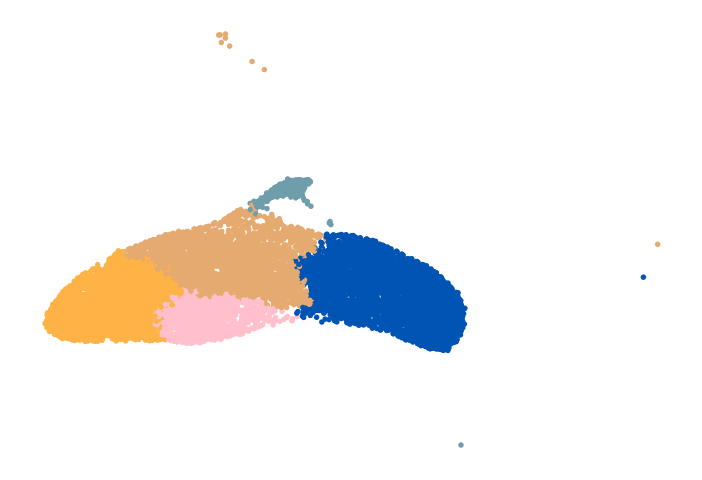

In [113]:
sc.pl.umap(adata_new_stroma, color='leiden_r1', size=30, legend_loc=None, 
           title = '', frameon=False,
           palette = mycolormap_stroma,
           show = True, legend_fontsize = 5, 
           save = 'adata_stroma_imputation2.pdf')

In [107]:
genes = fcHurdleSig_1vs2['gene_id'].tolist()
genes

['Gpx3',
 'C3',
 'Lum',
 'Inmt',
 'Dpt',
 'Clec3b',
 'Dcn',
 'Sult1e1',
 'Ccdc80',
 'Fbln1',
 'Meg3',
 'Gas1',
 'Gm12840',
 'Sparcl1',
 'Hmox1',
 'Ogn',
 'Col3a1',
 'Ugdh',
 'Col6a3',
 'Mfap5',
 'Tnfaip6',
 'Ccl7',
 'Ctla2a',
 'Gatm',
 'Col15a1',
 'Igfbp3',
 'Isyna1',
 'Cd200',
 'Hspa1a',
 'Pla2g7',
 'Mgp',
 'Tcf21',
 'Alpl',
 'Ckb',
 'Thy1',
 'Csrp1',
 'F2r',
 'Wfdc1',
 'Crispld2',
 'Gm48898',
 'Sfrp2',
 'Mmp2',
 'Igfbp5',
 'Gas6',
 'Rorb',
 'Nbl1',
 'Wnt2',
 'Cxcl14',
 'Mfge8',
 'Ifitm1',
 'Wif1']

In [108]:
genes[0:0]=['ETV4AAA','ETV4WT','EYFP']

In [109]:
genes[0:10]

['ETV4AAA',
 'ETV4WT',
 'EYFP',
 'Gpx3',
 'C3',
 'Lum',
 'Inmt',
 'Dpt',
 'Clec3b',
 'Dcn']

In [115]:
fcHurdle_1vs2

primerid    Pr(>Chisq)      coef     ci.hi     ci.lo           fdr
1       p00001  1.503533e-12  0.059455  0.075959  0.042951  9.863889e-12
2       p00002  7.524905e-05  0.016677  0.024936  0.008417  2.516591e-04
3       p00003  6.767831e-02       NaN       NaN       NaN  1.227207e-01
4       p00004  1.638341e-40  0.144613  0.166562  0.122665  2.811016e-39
5       p00005  9.488545e-01  0.000030  0.001553 -0.001493  9.746952e-01
...        ...           ...       ...       ...       ...           ...
18818   p19850  2.438688e-01       NaN       NaN       NaN  3.536013e-01
18819   p19851  4.343498e-01  0.000888  0.002416 -0.000640  5.533252e-01
18820   p19852  1.268348e-14  0.054871  0.068868  0.040873  9.458339e-14
18821   p19853  7.249380e-01 -0.002198  0.013368 -0.017764  8.131575e-01
18822   p19854  7.787706e-02  0.006326  0.012735 -0.000083  1.385795e-01

[18822 rows x 6 columns]

In [116]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle_1vs2, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * logFC

In [117]:
np.min(fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] > 0.0])

3.68e-321

In [118]:
fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321

<ipython-input-118-3ab27d3432d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-321


In [119]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * fcHurdle_genes['coef']
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00332    0.000000 -0.804131 -0.770212 -0.838050  9.980126e-322   
2       p00344    0.000000  1.352547  1.406390  1.298704  9.980126e-322   
3       p00372    0.000000  0.514705  0.540575  0.488836  9.980126e-322   
4       p00374    0.000000  0.671128  0.699427  0.642829  9.980126e-322   
5       p00502    0.000000 -0.972622 -0.942790 -1.002453  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18818   p15906    0.999948  0.000002  0.001132 -0.001127   1.000000e+00   
18819   p16147    1.000000       NaN       NaN       NaN   1.000000e+00   
18820   p16342    1.000000       NaN       NaN       NaN   1.000000e+00   
18821   p17733    0.999195  0.000221  0.011170 -0.010728   1.000000e+00   
18822   p19518    1.000000       NaN       NaN       NaN   1.000000e+00   

       gene_id               X2  n_cells  highly_variable     means  \
1          Fn1  Gene Expression     6906                1  0.195579   
2       Igfbp5  Gene Expression    14405                1  0.448768   
3         Wnt6  Gene Expression     3996                0  0.073044   
4       Wnt10a  Gene Expression     3915                1  0.074429   
5       Col6a3  Gene Expression     5159                1  0.135347   
...        ...              ...      ...              ...       ...   
18818  Gm40437  Gene Expression       46                0  0.000557   
18819  Gm47639  Gene Expression       11                0  0.000092   
18820       C9  Gene Expression       35                0  0.000352   
18821    Psmg1  Gene Expression     6823                0  0.076479   
18822     Tmc1  Gene Expression       10                0  0.000157   

       dispersions  dispersions_norm      mean       std       score  
1         1.931489         14.218443  0.195579  0.614620 -258.126755  
2         1.771581          7.360502  0.448768  0.891643  434.168780  
3         1.055125          3.826190  0.073044  0.277617  165.220858  
4         1.137464          4.828773  0.074429  0.290964  215.432710  
5         1.543856         10.263237  0.135347  0.457117 -312.212468  
...            ...               ...       ...       ...         ...  
18818     0.761925         -0.492667  0.000557  0.020609   -0.000000  
18819     0.889473          0.465992  0.000092  0.009067         NaN  
18820     0.654007         -0.821499  0.000352  0.015174         NaN  
18821     0.672162         -0.836885  0.076479  0.226730   -0.000000  
18822     1.310767          2.769559  0.000157  0.014354         NaN  

[18822 rows x 16 columns]

In [120]:
fcHurdle_genes.sort_values(by=['score'])
fcHurdle_genes

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p00332    0.000000 -0.804131 -0.770212 -0.838050  9.980126e-322   
2       p00344    0.000000  1.352547  1.406390  1.298704  9.980126e-322   
3       p00372    0.000000  0.514705  0.540575  0.488836  9.980126e-322   
4       p00374    0.000000  0.671128  0.699427  0.642829  9.980126e-322   
5       p00502    0.000000 -0.972622 -0.942790 -1.002453  9.980126e-322   
...        ...         ...       ...       ...       ...            ...   
18818   p15906    0.999948  0.000002  0.001132 -0.001127   1.000000e+00   
18819   p16147    1.000000       NaN       NaN       NaN   1.000000e+00   
18820   p16342    1.000000       NaN       NaN       NaN   1.000000e+00   
18821   p17733    0.999195  0.000221  0.011170 -0.010728   1.000000e+00   
18822   p19518    1.000000       NaN       NaN       NaN   1.000000e+00   

       gene_id               X2  n_cells  highly_variable     means  \
1          Fn1  Gene Expression     6906                1  0.195579   
2       Igfbp5  Gene Expression    14405                1  0.448768   
3         Wnt6  Gene Expression     3996                0  0.073044   
4       Wnt10a  Gene Expression     3915                1  0.074429   
5       Col6a3  Gene Expression     5159                1  0.135347   
...        ...              ...      ...              ...       ...   
18818  Gm40437  Gene Expression       46                0  0.000557   
18819  Gm47639  Gene Expression       11                0  0.000092   
18820       C9  Gene Expression       35                0  0.000352   
18821    Psmg1  Gene Expression     6823                0  0.076479   
18822     Tmc1  Gene Expression       10                0  0.000157   

       dispersions  dispersions_norm      mean       std       score  
1         1.931489         14.218443  0.195579  0.614620 -258.126755  
2         1.771581          7.360502  0.448768  0.891643  434.168780  
3         1.055125          3.826190  0.073044  0.277617  165.220858  
4         1.137464          4.828773  0.074429  0.290964  215.432710  
5         1.543856         10.263237  0.135347  0.457117 -312.212468  
...            ...               ...       ...       ...         ...  
18818     0.761925         -0.492667  0.000557  0.020609   -0.000000  
18819     0.889473          0.465992  0.000092  0.009067         NaN  
18820     0.654007         -0.821499  0.000352  0.015174         NaN  
18821     0.672162         -0.836885  0.076479  0.226730   -0.000000  
18822     1.310767          2.769559  0.000157  0.014354         NaN  

[18822 rows x 16 columns]

In [121]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

primerid    Pr(>Chisq)  coef  ci.hi  ci.lo           fdr   gene_id  \
726     p00675  1.130832e-65   NaN    NaN    NaN  2.931753e-64     Lemd1   
790     p14662  3.555953e-57   NaN    NaN    NaN  8.472172e-56    Mgat5b   
799     p12490  1.292259e-56   NaN    NaN    NaN  3.044167e-55  AI593442   
833     p05571  4.480232e-54   NaN    NaN    NaN  1.012328e-52    Sema3e   
1078    p15656  2.525086e-41   NaN    NaN    NaN  4.408828e-40      Gdf7   
...        ...           ...   ...    ...    ...           ...       ...   
18813   p14732  1.000000e+00   NaN    NaN    NaN  1.000000e+00   Gm16755   
18814   p14783  1.000000e+00   NaN    NaN    NaN  1.000000e+00   Gm40653   
18819   p16147  1.000000e+00   NaN    NaN    NaN  1.000000e+00   Gm47639   
18820   p16342  1.000000e+00   NaN    NaN    NaN  1.000000e+00        C9   
18822   p19518  1.000000e+00   NaN    NaN    NaN  1.000000e+00      Tmc1   

                    X2  n_cells  highly_variable     means  dispersions  \
726    Gene Expression      321                0  0.004366     0.808271   
790    Gene Expression      218                0  0.003056     0.788371   
799    Gene Expression      300                0  0.005155     1.064916   
833    Gene Expression      300                0  0.005517     1.086552   
1078   Gene Expression      179                0  0.002631     0.833573   
...                ...      ...              ...       ...          ...   
18813  Gene Expression       31                0  0.000285     0.832502   
18814  Gene Expression       18                0  0.000180     0.749588   
18819  Gene Expression       11                0  0.000092     0.889473   
18820  Gene Expression       35                0  0.000352     0.654007   
18822  Gene Expression       10                0  0.000157     1.310767   

       dispersions_norm      mean       std  score  
726           -0.204051  0.004366  0.059402    NaN  
790           -0.367330  0.003056  0.049086    NaN  
799            2.058250  0.005155  0.074094    NaN  
833            2.248969  0.005517  0.077424    NaN  
1078           0.013855  0.002631  0.046830    NaN  
...                 ...       ...       ...    ...  
18813          0.154484  0.000285  0.015393    NaN  
18814         -0.298876  0.000180  0.011606    NaN  
18819          0.465992  0.000092  0.009067    NaN  
18820         -0.821499  0.000352  0.015174    NaN  
18822          2.769559  0.000157  0.014354    NaN  

[2205 rows x 16 columns]

In [122]:
fcHurdle_genes.to_csv('./MAST/Fibroblasts_1vs2/fcHurdle_genes.csv')

### T cell compare

In [123]:
%%R
head(colData(sca))

        index            cells sample    age batch genotype_age n_counts
wk00001     0 AAACCTGGTGAGTGAC     TY 2weeks     1    TY_2weeks     2021
wk00002     1 AAATGCCAGAAGATTC     TY 2weeks     1    TY_2weeks     1515
wk00003     2 AAGACCTGTGAAAGAG     TY 2weeks     1    TY_2weeks     1638
wk00004     3 AATCCAGAGAGGTAGA     TY 2weeks     1    TY_2weeks     3136
wk00005     4 ACACCAAAGCGTGAGT     TY 2weeks     1    TY_2weeks     2637
wk00006     5 ACACCCTGTAATAGCA     TY 2weeks     1    TY_2weeks     2679
        log_counts n_genes    mt_frac doublet doublet_score     S_score
wk00001   7.668561     941 0.05560748       0  3.920398e-46 -0.02671526
wk00002   7.372746     759 0.04836683       0  3.920398e-46 -0.02315708
wk00003   7.427739     863 0.02615933       0  1.090523e-68 -0.02972500
wk00004   8.070906    1497 0.02000000       0  1.752931e-44  0.01330800
wk00005   7.939159    1209 0.05989305       0  2.543456e+02  0.10977404
wk00006   7.919356    1109 0.02581818       0  6.019739e-

In [124]:
%%R
# Create data subsets for luminal subpopulations
# columns cells and rows genes
sca_tcells_1vs2 <- subset(sca, with(colData(sca), leiden_r1 %in% c('T_cells_1','T_cells_2')))
head(sca_tcells_1vs2)

class: SingleCellAssay 
dim: 6 2808 
metadata(0):
assays(1): et
rownames(6): p00001 p00002 ... p00005 p00006
rowData names(10): gene_id 2 ... std primerid
colnames(2808): wk00003 wk00006 ... wk48874 wk48875
colData names(17): index cells ... leiden_r1 wellKey
reducedDimNames(0):
altExpNames(0):


In [125]:
%%R
str(colData(sca_tcells_1vs2))

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:2808] "wk00003" "wk00006" "wk00011" "wk00013" ...
  ..@ nrows          : int 2808
  ..@ listData       :List of 17
  .. ..$ index        : int [1:2808] 2 5 10 12 22 27 28 29 31 32 ...
  .. ..$ cells        : chr [1:2808] "AAGACCTGTGAAAGAG" "ACACCCTGTAATAGCA" "ACGGCCAGTTCAGTAC" "ACGGCCATCCAAGCCG" ...
  .. ..$ sample       : Factor w/ 4 levels "E4A","E4Ap53",..: 4 4 4 4 4 4 4 4 4 4 ...
  .. ..$ age          : Factor w/ 2 levels "2weeks","4months": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ batch        : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ genotype_age : Factor w/ 8 levels "TY_2weeks","EWT_2weeks",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ n_counts     : num [1:2808] 1638 2679 2180 2719 2032 ...
  .. ..$ log_counts   : num [1:2808] 7.43 7.92 7.74 7.93 7.66 ...
  .. ..$ n_genes      : int [1:2808] 863 1109 1112 1122 861 1018 1200 1067 821 735 ...
  .. ..$ mt_frac      : num [1:2808] 0.0262 

In [127]:
%%R
levels(colData(sca_tcells_1vs2)$leiden_r1)

 [1] "Basal_1"           "Fibroblasts_1"     "Basal_2"          
 [4] "Basal_3"           "Luminal_1"         "Fibroblasts_2"    
 [7] "Fibroblasts_3"     "Macrophage_1"      "Seminal_vesicle_1"
[10] "Luminal_2"         "Luminal_3"         "T_cells_1"        
[13] "Macrophage_2"      "Endothelial"       "Fibroblasts_4"    
[16] "Luminal_4"         "Dendritic_cells"   "Basal_4"          
[19] "T_cells_2"         "Luminal_5"         "Fibroblasts_5"    
[22] "Macrophage_3"      "Nerve_cells"       "Luminal_6"        
[25] "Seminal_vesicle_2"


In [128]:
%%R
levels(droplevels(colData(sca_tcells_1vs2)$leiden_r1))

[1] "T_cells_1" "T_cells_2"


In [129]:
%%R
colData(sca_tcells_1vs2)$leiden_r1 <- as.factor(as.character(colData(sca_tcells_1vs2)$leiden_r1))

In [130]:
%%R
levels(colData(sca_tcells_1vs2)$leiden_r1)

[1] "T_cells_1" "T_cells_2"


In [131]:
%%R
print("Dimensions before subsetting:")
print(dim(sca_tcells_1vs2))
# filter out the not expressed genes
sca_tcells_1vs2_filt = sca_tcells_1vs2[rowSums(assay(sca_tcells_1vs2)) != 0, ]
print("Dimensions after subsetting:")
print(dim(sca_tcells_1vs2_filt))

[1] "Dimensions before subsetting:"
[1] 19854  2808
[1] "Dimensions after subsetting:"
[1] 15704  2808


In [132]:
%%R
levels(colData(sca_tcells_1vs2_filt)$leiden_r1)

[1] "T_cells_1" "T_cells_2"


In [133]:
%%R
save(sca_tcells_1vs2_filt, file="./MAST/Tcells_1vs2/sca_tcells_1vs2_filt.rda")

In [134]:
%%R
colData(sca_tcells_1vs2_filt)$n_genes = scale(colData(sca_tcells_1vs2_filt)$n_genes)

In [135]:
%%R
mean(colData(sca_tcells_1vs2_filt)$n_genes)

[1] -3.188333e-16


In [136]:
%%R
sd(colData(sca_tcells_1vs2_filt)$n_genes)

[1] 1


In [138]:
%%R
#Define & run hurdle model
#Bayesian Linear Model With Zellner's G
#Used to fit the Bayesian normal-conjugate linear model with Zellner's g prior and mean zero coefficient priors. 
#Provides an object similar to the lm class

zlmCond_1vs2 <- zlm(formula = ~leiden_r1 + n_genes, sca=sca_tcells_1vs2_filt, method = "glm")
zlmCond_1vs2

Fitted zlm on 15704 genes and 2808 cells.
 Using GLMlike ~ leiden_r1 + n_genes 


In [139]:
%%R
summary_1vs2 <- summary(zlmCond_1vs2, logFC = TRUE, doLRT = 'leiden_r1T_cells_2')
summary_1vs2

Fitted zlm with top 2 genes per contrast:
( log fold change Z-score )
 primerid leiden_r1T_cells_2 n_genes
 p00694     -1.0               15.4*
 p08348    -76.2*               4.8 
 p14076    -76.6*              -0.6 
 p17109      3.7               15.2*


In [140]:
%%R
save(summary_1vs2, file="./MAST/Tcells_1vs2/summary_tcells_1vs2.rda")

In [141]:
%%R
head(summary_1vs2$datatable)

  primerid component           contrast Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C leiden_r1T_cells_2 0.07076186  0.43887618  0.01854715
2   p00001         C        (Intercept)         NA  1.20322168  0.95160602
3   p00001         C            n_genes         NA -0.03595098 -0.18310784
4   p00001         D leiden_r1T_cells_2 0.46431164  0.87350957 -0.39414645
5   p00001         D        (Intercept)         NA -3.88113581 -4.64238098
6   p00001         D            n_genes         NA  0.49992095  0.06233835
        coef           z
1  0.2287117   2.1329321
2  1.0774139  16.7850636
3 -0.1095294  -2.9176173
4  0.2396816   0.7411588
5 -4.2617584 -21.9453424
6  0.2811296   2.5183999


In [142]:
%%R
summaryDt = summary_1vs2$datatable
head(summaryDt)

  primerid component           contrast Pr(>Chisq)       ci.hi       ci.lo
1   p00001         C leiden_r1T_cells_2 0.07076186  0.43887618  0.01854715
2   p00001         C        (Intercept)         NA  1.20322168  0.95160602
3   p00001         C            n_genes         NA -0.03595098 -0.18310784
4   p00001         D leiden_r1T_cells_2 0.46431164  0.87350957 -0.39414645
5   p00001         D        (Intercept)         NA -3.88113581 -4.64238098
6   p00001         D            n_genes         NA  0.49992095  0.06233835
        coef           z
1  0.2287117   2.1329321
2  1.0774139  16.7850636
3 -0.1095294  -2.9176173
4  0.2396816   0.7411588
5 -4.2617584 -21.9453424
6  0.2811296   2.5183999


In [143]:
%%R
fcHurdle_1vs2 <- merge(summaryDt[contrast=='leiden_r1T_cells_2' & component=='H',.(primerid, `Pr(>Chisq)`)], #hurdle P values
                  summaryDt[contrast=='leiden_r1T_cells_2' & component=='logFC', .(primerid, coef, ci.hi, ci.lo)], 
                  by='primerid') #logFC coefficients

In [144]:
%%R -o fcHurdle_1vs2
head(fcHurdle_1vs2[,fdr:=p.adjust(`Pr(>Chisq)`, 'fdr')])

  primerid Pr(>Chisq)         coef      ci.hi        ci.lo        fdr
1   p00001 0.14951332  0.008010639 0.02128374 -0.005262457 0.39519918
2   p00002 0.14420048  0.005699165 0.01255246 -0.001154130 0.38749560
3   p00004 0.01045018  0.041025096 0.07175289  0.010297302 0.05918128
4   p00005 0.06704027          NaN        NaN          NaN 0.23928129
5   p00008 0.60843377          NaN        NaN          NaN 0.81463415
6   p00009 0.27593200 -0.004858299 0.03013585 -0.039852451 0.55019394


In [145]:
fcHurdle_1vs2.to_csv('./MAST/Tcells_1vs2/fcHurdle_tcells_1vs2.csv')

In [146]:
%%R -o fcHurdleSig_1vs2
library(data.table)
fcHurdleSig_1vs2 <- merge(fcHurdle_1vs2[fdr<.05 & abs(coef)>log2(1.8)], as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdleSig_1vs2, fdr)

In [147]:
fcHurdleSig_1vs2.sort_values(by=['coef'], axis=0, ascending=True, inplace=True)

In [148]:
fcHurdleSig_1vs2

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
4    p14076   0.000000e+00 -3.407815 -3.320598 -3.495031   0.000000e+00   
3    p08348   0.000000e+00 -2.047822 -1.995136 -2.100509   0.000000e+00   
5    p00910  1.410676e-279 -1.595803 -1.534436 -1.657170  4.430653e-276   
26   p00973  2.005339e-140 -1.302646 -1.226917 -1.378375  9.262306e-138   
22   p11759  5.843261e-165 -1.269364 -1.201251 -1.337477  3.529329e-162   
20   p14766  6.886496e-187 -1.254806 -1.192415 -1.317197  5.149787e-184   
11   p09024  4.692088e-212 -1.195775 -1.137812 -1.253737  6.698596e-209   
17   p19299  1.132967e-194 -1.124705 -1.066941 -1.182469  1.046595e-191   
24   p19464  4.289607e-150 -1.118722 -1.043786 -1.193658  2.245466e-147   
27   p08224  6.315986e-133 -1.003350 -0.942332 -1.064367  2.680709e-130   
23   p17209  3.626006e-162 -0.975110 -0.921413 -1.028807  2.033671e-159   
25   p02118  5.458636e-141 -0.885937 -0.831428 -0.940446  2.597649e-138   
18   p16325  6.478587e-194  0.874508  0.933917  0.815099  5.652208e-191   
29   p18116  1.806130e-111  0.892808  0.963005  0.822610  6.302992e-109   
10   p09226  2.892545e-219  0.905754  0.978491  0.833017  4.542453e-216   
30   p09791   1.536184e-91  0.917357  1.004824  0.829891   3.600632e-89   
12   p16258  6.359706e-210  0.931631  0.992836  0.870425  8.322735e-207   
15   p04390  2.212582e-201  0.959652  1.019056  0.900248  2.316426e-198   
8    p15015  4.758226e-224  0.984701  1.053381  0.916021  9.340398e-221   
28   p00293  1.571720e-132  0.988026  1.063929  0.912123  6.495338e-130   
21   p12690  3.401178e-175  1.038390  1.103891  0.972889  2.322265e-172   
13   p14858  3.163120e-207  1.088964  1.163837  1.014090  3.821049e-204   
6    p00508  1.384768e-268  1.097355  1.158781  1.035928  3.624399e-265   
19   p03785  4.070233e-191  1.266926  1.346918  1.186934  3.195947e-188   
9    p04253  1.396739e-222  1.278493  1.354857  1.202129  2.437154e-219   
16   p11680  3.381553e-198  1.405410  1.514826  1.295994  3.318995e-195   
7    p15598  6.933625e-234  1.589134  1.665407  1.512860  1.555509e-230   
14   p13296  1.292614e-206  1.685151  1.780490  1.589813  1.449944e-203   
2    p07031   0.000000e+00  1.723199  1.792160  1.654238   0.000000e+00   
1    p07030   0.000000e+00  1.728904  1.798603  1.659205   0.000000e+00   

     gene_id               X2  n_cells  highly_variable     means  \
4       Ccl5  Gene Expression     4441                1  0.180794   
3       Nkg7  Gene Expression     2088                1  0.088337   
5       Xcl1  Gene Expression     1644                1  0.066149   
26    Fcer1g  Gene Expression     8288                1  0.365419   
22      Gzmb  Gene Expression     1320                1  0.056133   
20       Cd7  Gene Expression     1487                1  0.056627   
11     Il21r  Gene Expression     3701                1  0.098294   
17      Ctsw  Gene Expression     2047                1  0.063824   
24  AW112010  Gene Expression     8951                1  0.213099   
27    Tyrobp  Gene Expression     8001                1  0.341078   
23     Litaf  Gene Expression    28997                0  0.627478   
25     Dusp2  Gene Expression     5917                1  0.140711   
18   Selenop  Gene Expression    35931                0  1.058416   
29      Pim1  Gene Expression    23314                0  0.621260   
10   Cd163l1  Gene Expression      429                1  0.016570   
30      Cstb  Gene Expression    42510                0  1.454148   
12       Ckb  Gene Expression    12782                1  0.303714   
15    Tmem64  Gene Expression    12846                0  0.188573   
8      Pxdc1  Gene Expression    14286                0  0.259803   
28      Icos  Gene Expression     1430                1  0.046745   
21      Rora  Gene Expression    12412                0  0.201913   
13   Tcrg-C1  Gene Expression      769                1  0.025888   
6      Ramp1  Gene Expression    16332                0  0.302881   
19    S100a4  Gene Ex

In [149]:
fcHurdleSig_1vs2.to_csv('./MAST/Tcells_1vs2/fcHurdleSig_fdr005coef_1vs2.csv')

In [150]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('./MAST/Tcells_1vs2/fcHurdleSig_1vs2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(fcHurdleSig_1vs2, f)

In [ ]:
import pickle

# Getting back the objects:
with open('./MAST/Tcells_1vs2/fcHurdleSig_1vs2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    fcHurdleSig_1vs2 = pickle.load(f)

In [151]:
import pickle

# Getting back the objects:
with open('adata_cluster_annotations3.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

In [152]:
adata.obs['leiden_r1'].cat.categories

Index(['Basal_1', 'Fibroblasts_1', 'Basal_2', 'Basal_3', 'Luminal_1',
       'Fibroblasts_2', 'Fibroblasts_3', 'Macrophage_1', 'Seminal_vesicle_1',
       'Luminal_2', 'Luminal_3', 'T_cells_1', 'Macrophage_2', 'Endothelial',
       'Fibroblasts_4', 'Luminal_4', 'Dendritic_cells', 'Basal_4', 'T_cells_2',
       'Luminal_5', 'Fibroblasts_5', 'Macrophage_3', 'Nerve_cells',
       'Luminal_6', 'Seminal_vesicle_2'],
      dtype='object')

In [156]:
adata_macrophage = adata[adata.obs['leiden_r1'].isin(['Macrophage_1', 'Macrophage_2', 'Macrophage_3', 'Dendritic_cells'])]
adata_tcells = adata[adata.obs['leiden_r1'].isin(['T_cells_1', 'T_cells_2'])]

/home/dan/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [157]:
adata_macrophage.obs['leiden_r1'].cat.reorder_categories(['Macrophage_1', 'Macrophage_2', 'Macrophage_3', 'Dendritic_cells'], 
                                                      inplace=True)
adata_tcells.obs['leiden_r1'].cat.reorder_categories(['T_cells_1', 'T_cells_2'], inplace=True)

In [158]:
# luminal 1,6,4,2,3,5
mycolormap_macrophage = ["#db7093", "#5b5da7", "#557100", "yellow",]

In [159]:
# luminal 1,6,4,2,3,5
mycolormap_tcells = ["#5a5a97", "gray"]

Trying to set attribute `.uns` of view, copying.


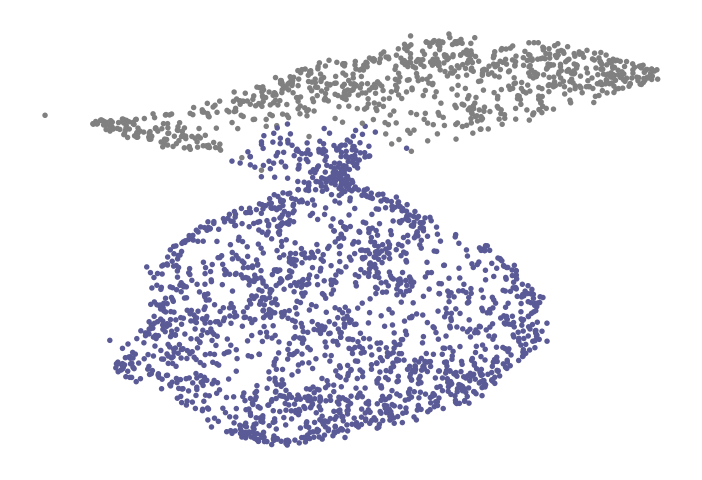

In [160]:
sc.pl.umap(adata_tcells, color='leiden_r1', size=30, legend_loc=None, 
           title = '', frameon=False, palette = mycolormap_tcells,
           show = True, legend_fontsize = 10, save = 'adata_tcells2.pdf')

In [166]:
genes = fcHurdleSig_1vs2['gene_id'].tolist()
genes

['Ccl5',
 'Nkg7',
 'Xcl1',
 'Fcer1g',
 'Gzmb',
 'Cd7',
 'Il21r',
 'Ctsw',
 'AW112010',
 'Tyrobp',
 'Litaf',
 'Dusp2',
 'Selenop',
 'Pim1',
 'Cd163l1',
 'Cstb',
 'Ckb',
 'Tmem64',
 'Pxdc1',
 'Icos',
 'Rora',
 'Tcrg-C1',
 'Ramp1',
 'S100a4',
 'Lmo4',
 'Trdc',
 'Emb',
 'Ramp3',
 'Tmem176a',
 'Tmem176b']

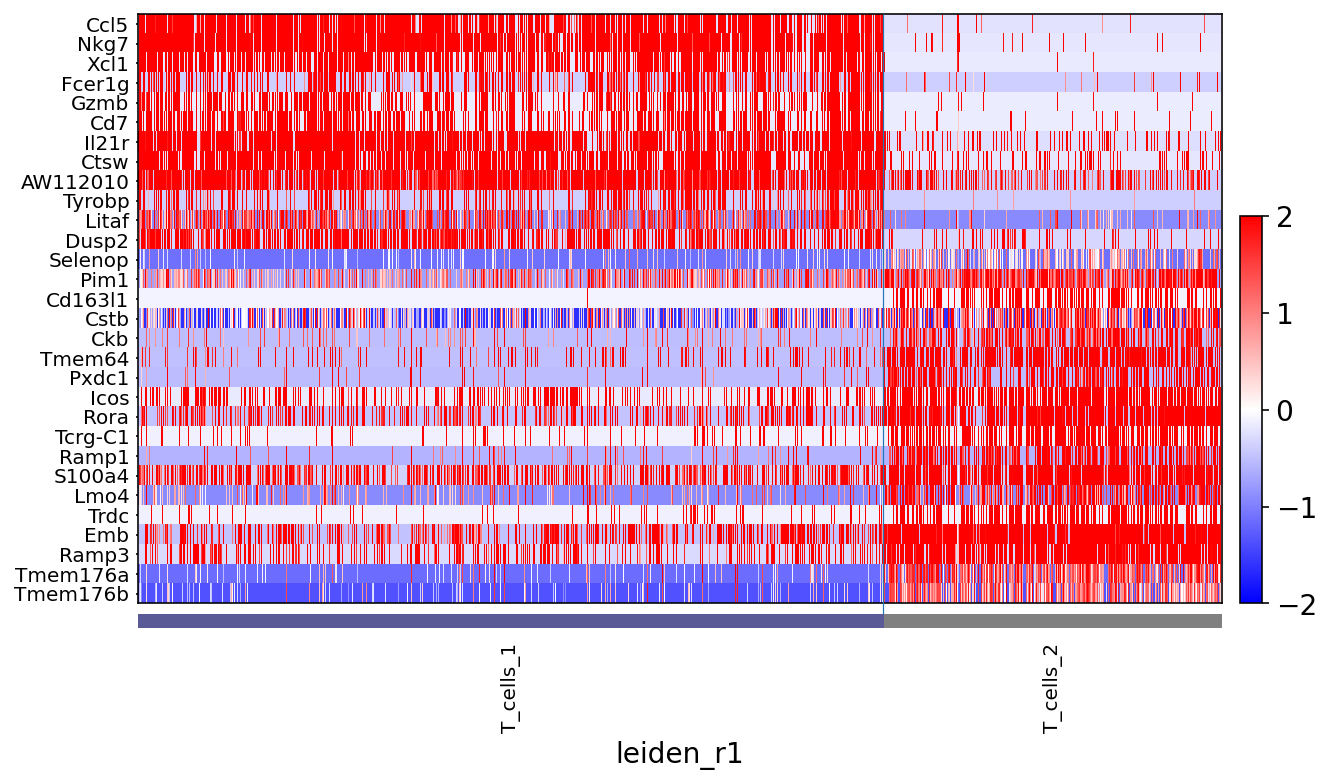

In [167]:
plt.rcParams.update({'font.size': 12})
sc.pl.heatmap(adata_tcells, genes, groupby='leiden_r1', 
              use_raw=False,
              vmin=-2, vmax=2, show_gene_labels= True,
              cmap='bwr', dendrogram=False, swap_axes=True, 
              save = "Tcells_imputation_fcHurdleSig_1vs2.pdf")

In [168]:
fcHurdle_1vs2

primerid  Pr(>Chisq)      coef     ci.hi     ci.lo       fdr
1       p00001    0.149513  0.008011  0.021284 -0.005262  0.395199
2       p00002    0.144200  0.005699  0.012552 -0.001154  0.387496
3       p00004    0.010450  0.041025  0.071753  0.010297  0.059181
4       p00005    0.067040       NaN       NaN       NaN  0.239281
5       p00008    0.608434       NaN       NaN       NaN  0.814634
...        ...         ...       ...       ...       ...       ...
15700   p19849    0.127153       NaN       NaN       NaN  0.358944
15701   p19851    0.435694       NaN       NaN       NaN  0.678163
15702   p19852    0.019044 -0.053045 -0.015081 -0.091009  0.096382
15703   p19853    0.876022  0.000951  0.034549 -0.032647  0.962467
15704   p19854    0.020817  0.008734  0.016603  0.000864  0.102290

[15704 rows x 6 columns]

In [169]:
%%R -o fcHurdle_genes
library(data.table)
fcHurdle_genes <- merge(fcHurdle_1vs2, as.data.table(mcols(sca)), by='primerid')
setorder(fcHurdle_genes, fdr)

#### -log(p-value) * logFC

In [170]:
np.min(fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] > 0.0])

4.430652545319356e-276

In [171]:
fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-276

<ipython-input-171-3218ebb1f22c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcHurdle_genes['fdr'][fcHurdle_genes['fdr'] == 0.0] = 1.0e-276


In [172]:
fcHurdle_genes['score'] = -np.log10(fcHurdle_genes['fdr']) * fcHurdle_genes['coef']
fcHurdle_genes

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p07030   0.000000e+00  1.728904  1.798603  1.659205  1.000000e-276   
2       p07031   0.000000e+00  1.723199  1.792160  1.654238  1.000000e-276   
3       p08348   0.000000e+00 -2.047822 -1.995136 -2.100509  1.000000e-276   
4       p14076   0.000000e+00 -3.407815 -3.320598 -3.495031  1.000000e-276   
5       p00910  1.410676e-279 -1.595803 -1.534436 -1.657170  4.430653e-276   
...        ...            ...       ...       ...       ...            ...   
15700   p18427   9.954569e-01       NaN       NaN       NaN   1.000000e+00   
15701   p18744   9.971056e-01 -0.001190  0.039943 -0.042324   1.000000e+00   
15702   p19258   9.947149e-01  0.000026  0.002892 -0.002839   1.000000e+00   
15703   p19490   9.944704e-01  0.000136  0.024241 -0.023968   1.000000e+00   
15704   p19754   9.961434e-01 -0.000166  0.004609 -0.004942   1.000000e+00   

        gene_id               X2  n_cells  highly_variable     means  \
1      Tmem176b  Gene Expression    37670                0  1.322325   
2      Tmem176a  Gene Expression    34148                0  1.042844   
3          Nkg7  Gene Expression     2088                1  0.088337   
4          Ccl5  Gene Expression     4441                1  0.180794   
5          Xcl1  Gene Expression     1644                1  0.066149   
...         ...              ...      ...              ...       ...   
15700      Ptk7  Gene Expression     5821                0  0.082330   
15701     Rab18  Gene Expression    27199                0  0.466166   
15702     Lrfn4  Gene Expression     2367                0  0.025833   
15703      Dtx4  Gene Expression     2223                0  0.030021   
15704     As3mt  Gene Expression     4626                0  0.055637   

       dispersions  dispersions_norm      mean       std       score  
1         0.731127          1.096059  1.322325  0.983253  477.177559  
2         0.790777          1.455202  1.042844  0.908106  475.602983  
3         2.429485         20.560776  0.088337  0.463263 -565.198998  
4         3.539961         32.785789  0.180794  0.800003 -940.556841  
5         2.521157         22.003786  0.066149  0.408378 -439.410001  
...            ...               ...       ...       ...         ...  
15700     0.796556          0.677779  0.082330  0.256086         NaN  
15701     0.572299          0.139773  0.466166  0.516514    0.000000  
15702     0.712327         -0.724830  0.025833  0.135653   -0.000000  
15703     0.866560          0.867536  0.030021  0.161291   -0.000000  
15704     0.711449         -0.567923  0.055637  0.198955    0.000000  

[15704 rows x 16 columns]

In [173]:
fcHurdle_genes.sort_values(by=['score'])
fcHurdle_genes

primerid     Pr(>Chisq)      coef     ci.hi     ci.lo            fdr  \
1       p07030   0.000000e+00  1.728904  1.798603  1.659205  1.000000e-276   
2       p07031   0.000000e+00  1.723199  1.792160  1.654238  1.000000e-276   
3       p08348   0.000000e+00 -2.047822 -1.995136 -2.100509  1.000000e-276   
4       p14076   0.000000e+00 -3.407815 -3.320598 -3.495031  1.000000e-276   
5       p00910  1.410676e-279 -1.595803 -1.534436 -1.657170  4.430653e-276   
...        ...            ...       ...       ...       ...            ...   
15700   p18427   9.954569e-01       NaN       NaN       NaN   1.000000e+00   
15701   p18744   9.971056e-01 -0.001190  0.039943 -0.042324   1.000000e+00   
15702   p19258   9.947149e-01  0.000026  0.002892 -0.002839   1.000000e+00   
15703   p19490   9.944704e-01  0.000136  0.024241 -0.023968   1.000000e+00   
15704   p19754   9.961434e-01 -0.000166  0.004609 -0.004942   1.000000e+00   

        gene_id               X2  n_cells  highly_variable     means  \
1      Tmem176b  Gene Expression    37670                0  1.322325   
2      Tmem176a  Gene Expression    34148                0  1.042844   
3          Nkg7  Gene Expression     2088                1  0.088337   
4          Ccl5  Gene Expression     4441                1  0.180794   
5          Xcl1  Gene Expression     1644                1  0.066149   
...         ...              ...      ...              ...       ...   
15700      Ptk7  Gene Expression     5821                0  0.082330   
15701     Rab18  Gene Expression    27199                0  0.466166   
15702     Lrfn4  Gene Expression     2367                0  0.025833   
15703      Dtx4  Gene Expression     2223                0  0.030021   
15704     As3mt  Gene Expression     4626                0  0.055637   

       dispersions  dispersions_norm      mean       std       score  
1         0.731127          1.096059  1.322325  0.983253  477.177559  
2         0.790777          1.455202  1.042844  0.908106  475.602983  
3         2.429485         20.560776  0.088337  0.463263 -565.198998  
4         3.539961         32.785789  0.180794  0.800003 -940.556841  
5         2.521157         22.003786  0.066149  0.408378 -439.410001  
...            ...               ...       ...       ...         ...  
15700     0.796556          0.677779  0.082330  0.256086         NaN  
15701     0.572299          0.139773  0.466166  0.516514    0.000000  
15702     0.712327         -0.724830  0.025833  0.135653   -0.000000  
15703     0.866560          0.867536  0.030021  0.161291   -0.000000  
15704     0.711449         -0.567923  0.055637  0.198955    0.000000  

[15704 rows x 16 columns]

In [174]:
fcHurdle_genes[fcHurdle_genes['coef'].isnull().values]

primerid    Pr(>Chisq)  coef  ci.hi  ci.lo           fdr  gene_id  \
157     p14512  3.835547e-47   NaN    NaN    NaN  3.836525e-45    Prr29   
247     p02547  8.014252e-31   NaN    NaN    NaN  5.095377e-29    Sulf2   
315     p08254  1.289864e-24   NaN    NaN    NaN  6.430485e-23    Ffar2   
360     p13704  9.704942e-22   NaN    NaN    NaN  4.233511e-20      Ubb   
361     p07659  1.221369e-21   NaN    NaN    NaN  5.305512e-20    Klri2   
...        ...           ...   ...    ...    ...           ...      ...   
15693   p17487  1.000000e+00   NaN    NaN    NaN  1.000000e+00    Stfa3   
15696   p17967  1.000000e+00   NaN    NaN    NaN  1.000000e+00    Rpl3l   
15697   p18117  1.000000e+00   NaN    NaN    NaN  1.000000e+00  Tmem217   
15698   p18264  1.000000e+00   NaN    NaN    NaN  1.000000e+00   Ly6g6e   
15700   p18427  9.954569e-01   NaN    NaN    NaN  1.000000e+00     Ptk7   

                    X2  n_cells  highly_variable     means  dispersions  \
157    Gene Expression      199                0  0.002695     0.896735   
247    Gene Expression     3055                0  0.059620     1.104171   
315    Gene Expression       95                0  0.001530     1.056974   
360    Gene Expression    49650                0  3.254134     0.177512   
361    Gene Expression      209                0  0.004143     1.230435   
...                ...      ...              ...       ...          ...   
15693  Gene Expression       20                0  0.000221     0.840113   
15696  Gene Expression      166                0  0.002445     0.947335   
15697  Gene Expression       14                0  0.000148     0.825817   
15698  Gene Expression     1178                0  0.009620     0.552345   
15700  Gene Expression     5821                0  0.082330     0.796556   

       dispersions_norm      mean       std  score  
157            0.546507  0.002695  0.049160    NaN  
247            4.330338  0.059620  0.256576    NaN  
315            1.715630  0.001530  0.040217    NaN  
360           -2.237189  3.254134  0.760031    NaN  
361            3.517292  0.004143  0.071401    NaN  
...                 ...       ...       ...    ...  
15693          0.196101  0.000221  0.013616    NaN  
15696          0.973221  0.002445  0.048129    NaN  
15697          0.117930  0.000148  0.011057    NaN  
15698         -2.092037  0.009620  0.072895    NaN  
15700          0.677779  0.082330  0.256086    NaN  

[3096 rows x 16 columns]

In [175]:
fcHurdle_genes.to_csv('./MAST/Tcells_1vs2/fcHurdle_genes.csv')